# Modelisation segmentation olist

## Import des librairies

In [66]:
import hdbscan
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
import pandas as pd
import numpy as np
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Import des données

In [67]:
df_segmentation = pd.read_csv('df_preprocessing.csv')
df_segmentation = df_segmentation.set_index('identifiant_client')
df_segmentation.head()

,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services
identifiant_client,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.825585,-0.200448,-0.074179,credit_card,cajamar,SP,Jeudi,bed_bath_table,0.341400,-0.066068,-0.162143,-0.206984,-0.058154,-0.105316,-0.202720,-0.077747,-0.016793,-0.008695
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.805902,-0.200448,-0.574410,credit_card,osasco,SP,Lundi,health_beauty,-0.217053,-0.066068,-0.162143,-0.206984,-0.058154,-0.105316,0.034744,-0.077747,-0.016793,-0.008695
0000f46a3911fa3c0805444483337064,1.969343,-0.200448,-0.348630,credit_card,sao jose,SC,Vendredi,stationery,-0.217053,-0.066068,-0.162143,-0.206984,-0.058154,-0.105316,-0.202720,-0.077747,-0.016793,-0.008695
0000f6ccb0745a6a4b88665a16c9f078,0.552197,-0.200448,-0.542459,credit_card,belem,PA,Jeudi,telephony,-0.217053,0.023856,-0.162143,-0.206984,-0.058154,-0.105316,-0.202720,-0.077747,-0.016793,-0.008695
0004aac84e0df4da2b147fca70cf8255,0.335688,-0.200448,0.151602,credit_card,sorocaba,SP,Mardi,telephony,-0.217053,0.339829,-0.162143,-0.206984,-0.058154,-0.105316,-0.202720,-0.077747,-0.016793,-0.008695


## Modélisation clustering : Test de différents modèles 

Nous allons maintenant testé différents modèle de clustering et choisir le plus pertinant pour nos données. Pour tester le K-means, nous allons utiliser utiliser seulement, les variables numériques dans notre jeux de données, car en effet le l'algorithme k-means gère difficilement les variables catégorielles ce qui peut créer des résultats faussés.

### K-mean

In [4]:
# Create dataframe for kmeans model and evaluation
# Keep only numerical for kmeans
columns_depense = df_segmentation.filter(like='dépense').columns
other_columns = ['récence', 'fréquence', 'montant']
all_columns = list(columns_depense) + other_columns
# Merge all columns selected to a new dataframe
df_kmean_segmentation = df_segmentation[all_columns]
df_kmean_segmentation.head()

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant
identifiant_client,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.509722,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986
0000f46a3911fa3c0805444483337064,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607
0000f6ccb0745a6a4b88665a16c9f078,-0.263807,0.160607,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430
0004aac84e0df4da2b147fca70cf8255,-0.263807,1.326736,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209


### Recherche du meilleur nombres de clusters

#### Elbow

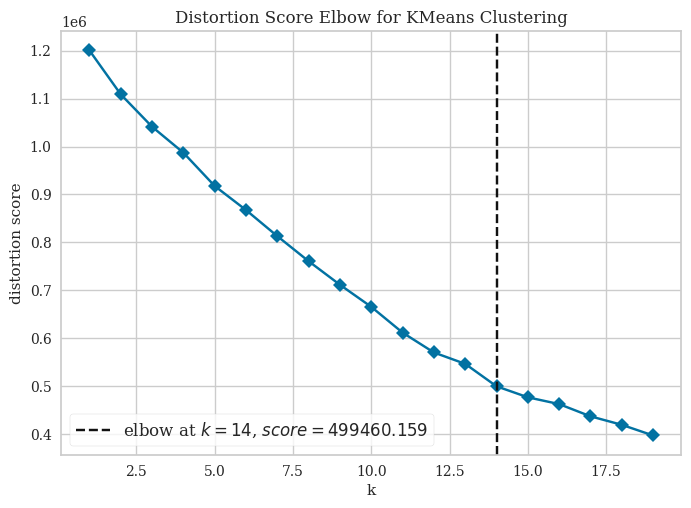

In [5]:

# Instantiate the clustering model and visualizer
model = KMeans(max_iter=500, n_init=10, random_state=42)
# Visualize the optimal number of clusters kmeans
visualizer = KElbowVisualizer(model, k=(1, 20), timings=False)
visualizer.fit(df_kmean_segmentation)
visualizer.show()
# Capture the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

#### Silhouette Score

In [61]:
silhouette_scores = []
for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    print(f"Calculating Silhouette score for {n_clusters} clusters...")
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    silhouette_avg = silhouette_score(df_kmean_segmentation, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Convert to DataFrame for easier viewing
silhouette_df = pd.DataFrame(silhouette_scores, columns=[
                             'n_clusters', 'silhouette_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_silhouette = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax(
)]

print("Best Silhouette Score:")
print(best_n_clusters_silhouette)

Calculating Silhouette score for 2 clusters...
Calculating Silhouette score for 3 clusters...
Calculating Silhouette score for 4 clusters...
Calculating Silhouette score for 5 clusters...


KeyboardInterrupt: 

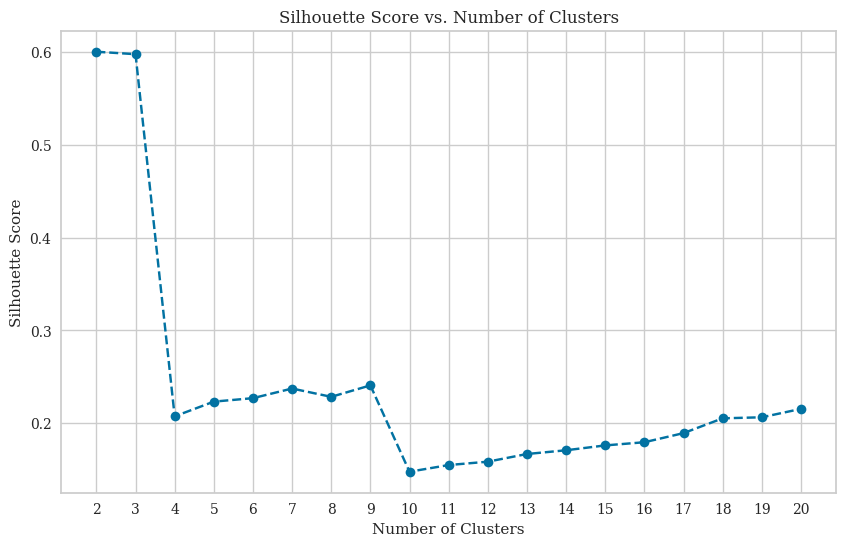

In [ ]:
# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(silhouette_df['n_clusters'],
         silhouette_df['silhouette_score'], marker='o', linestyle='--')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [ ]:

davies_bouldin_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating Davies-Bouldin score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    db_score = davies_bouldin_score(df_kmean_segmentation, cluster_labels)
    davies_bouldin_scores.append((n_clusters, db_score))

# Convert to DataFrame for easier viewing
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=[
                                 'n_clusters', 'davies_bouldin_score'])

# Find the best score and corresponding number of clusters (lowest score is better)
best_n_clusters_davies_bouldin = davies_bouldin_df.loc[davies_bouldin_df['davies_bouldin_score'].idxmin(
)]

print("Best Davies-Bouldin Index:")
print(best_n_clusters_davies_bouldin)

Calculating Davies-Bouldin score for 2 clusters...
Calculating Davies-Bouldin score for 3 clusters...
Calculating Davies-Bouldin score for 4 clusters...
Calculating Davies-Bouldin score for 5 clusters...
Calculating Davies-Bouldin score for 6 clusters...
Calculating Davies-Bouldin score for 7 clusters...
Calculating Davies-Bouldin score for 8 clusters...
Calculating Davies-Bouldin score for 9 clusters...
Calculating Davies-Bouldin score for 10 clusters...
Calculating Davies-Bouldin score for 11 clusters...
Calculating Davies-Bouldin score for 12 clusters...
Calculating Davies-Bouldin score for 13 clusters...
Calculating Davies-Bouldin score for 14 clusters...
Calculating Davies-Bouldin score for 15 clusters...
Calculating Davies-Bouldin score for 16 clusters...
Calculating Davies-Bouldin score for 17 clusters...
Calculating Davies-Bouldin score for 18 clusters...
Calculating Davies-Bouldin score for 19 clusters...
Calculating Davies-Bouldin score for 20 clusters...
Best Davies-Bouldin 

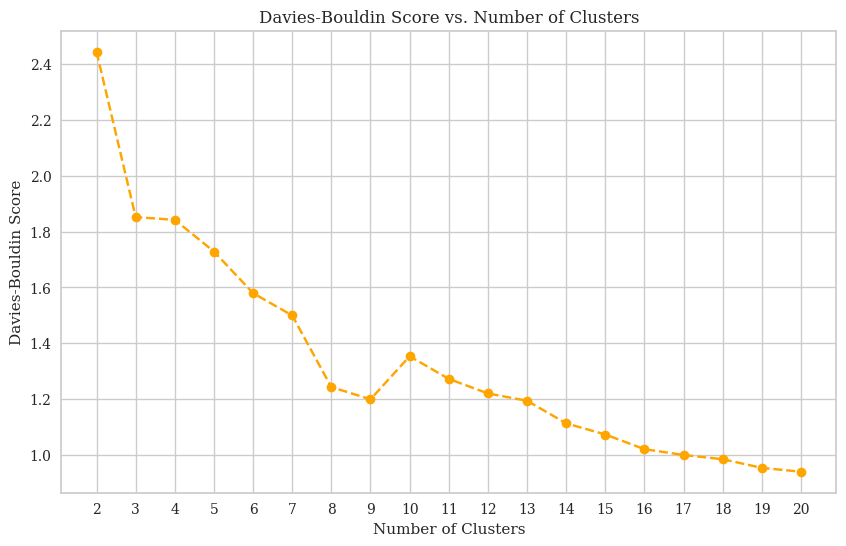

In [ ]:
# Plotting Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(davies_bouldin_df['n_clusters'], davies_bouldin_df['davies_bouldin_score'],
         marker='o', linestyle='--', color='orange')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [ ]:
calinski_harabasz_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating calinski harabasz score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_segmentation)
    ch_score = calinski_harabasz_score(df_kmean_segmentation, cluster_labels)
    calinski_harabasz_scores.append((n_clusters, ch_score))

# Convert to DataFrame for easier viewing
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=[
                                    'n_clusters', 'calinski_harabasz_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_calinski_harabasz = calinski_harabasz_df.loc[
    calinski_harabasz_df['calinski_harabasz_score'].idxmax()]

print("Best Calinski-Harabasz Index:")
print(best_n_clusters_calinski_harabasz)

Calculating calinski harabasz score for 2 clusters...
Calculating calinski harabasz score for 3 clusters...
Calculating calinski harabasz score for 4 clusters...
Calculating calinski harabasz score for 5 clusters...
Calculating calinski harabasz score for 6 clusters...
Calculating calinski harabasz score for 7 clusters...
Calculating calinski harabasz score for 8 clusters...
Calculating calinski harabasz score for 9 clusters...
Calculating calinski harabasz score for 10 clusters...
Calculating calinski harabasz score for 11 clusters...
Calculating calinski harabasz score for 12 clusters...
Calculating calinski harabasz score for 13 clusters...
Calculating calinski harabasz score for 14 clusters...
Calculating calinski harabasz score for 15 clusters...
Calculating calinski harabasz score for 16 clusters...
Calculating calinski harabasz score for 17 clusters...
Calculating calinski harabasz score for 18 clusters...
Calculating calinski harabasz score for 19 clusters...
Calculating calins

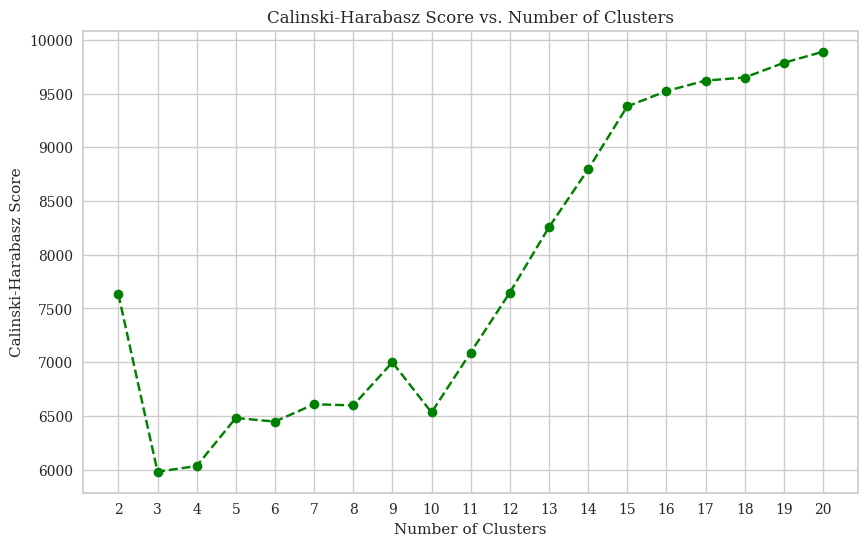

In [ ]:
# Plotting Calinski-Harabasz Scores
plt.figure(figsize=(10, 6))
plt.plot(calinski_harabasz_df['n_clusters'], calinski_harabasz_df['calinski_harabasz_score'],
         marker='o', linestyle='--', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

Avec les résultats suivi ont peut remarquer que le bon de clusters a choisir est 14

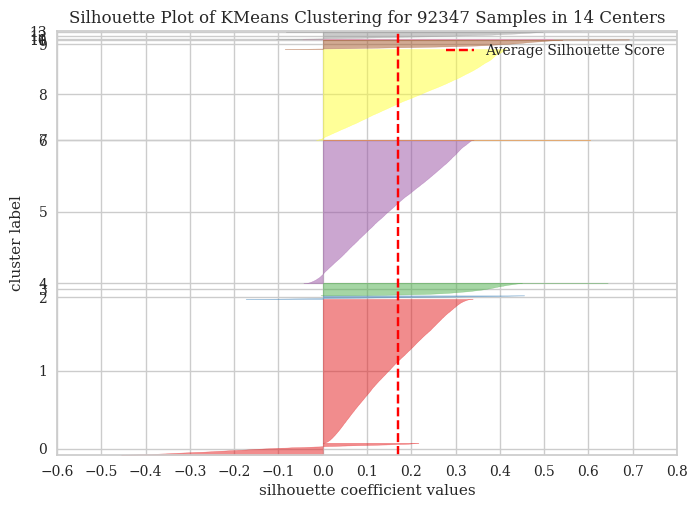

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 92347 Samples in 14 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [6]:
# Initialisation

# k-means with best cluster
kmeans_segmentation = KMeans(
    n_clusters=optimal_clusters, init='k-means++', random_state=42, max_iter=500)
# Fit the K-Means model and predict the cluster labels
df_kmean_segmentation['Cluster_Label'] = kmeans_segmentation.fit_predict(
    df_kmean_segmentation)

# Evaluation
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Silhouette_Score'] = silhouette_avg

# Calculate the Davies-Bouldin Index
db_score = davies_bouldin_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Davies_Bouldin_Score'] = db_score

# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(
    df_kmean_segmentation, df_kmean_segmentation['Cluster_Label'])
df_kmean_segmentation['Calinski_Harabasz_Score'] = ch_score
# List of columns to exclude (evaluation metrics and cluster labels)
exclude_columns = ['Calinski_Harabasz_Score',
                   'Cluster_Label', 'Davies_Bouldin_Score', 'Silhouette_Score']

# Select only the features used for K-Means clustering
kmeans_features = df_kmean_segmentation.drop(columns=exclude_columns)
# Visualisation
# Visualize the clusters with Silhouette Visualizer
visualizer = SilhouetteVisualizer(kmeans_segmentation, k=optimal_clusters)
visualizer.fit(kmeans_features)
visualizer.show()

In [ ]:
display(df_kmean_segmentation)

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score
identifiant_client,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.509722,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830,5,0.572925,0.79598,19875.669707
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986,5,0.572925,0.79598,19875.669707
0000f46a3911fa3c0805444483337064,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607,8,0.572925,0.79598,19875.669707
0000f6ccb0745a6a4b88665a16c9f078,-0.263807,0.160607,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430,1,0.572925,0.79598,19875.669707
0004aac84e0df4da2b147fca70cf8255,-0.263807,1.326736,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209,1,0.572925,0.79598,19875.669707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.548426,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.049172,-0.162673,0.162413,1,0.572925,0.79598,19875.669707
fffea47cd6d3cc0a88bd621562a9d061,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,-0.151745,-0.235404,1.195061,-0.051336,-0.02455,0.160591,-0.162673,-0.461073,1,0.572925,0.79598,19875.669707
ffff371b4d645b6ecea244b27531430a,-0.263807,-0.171268,-0.200430,-0.24093,-0.059443,0.729441,-0.235404,-0.078251,-0.051336,-0.02455,2.166120,-0.162673,-0.275680,8,0.572925,0.79598,19875.669707


In [ ]:
df_kmean_segmentation['Silhouette_Score'].mean()

0.5729246537044378

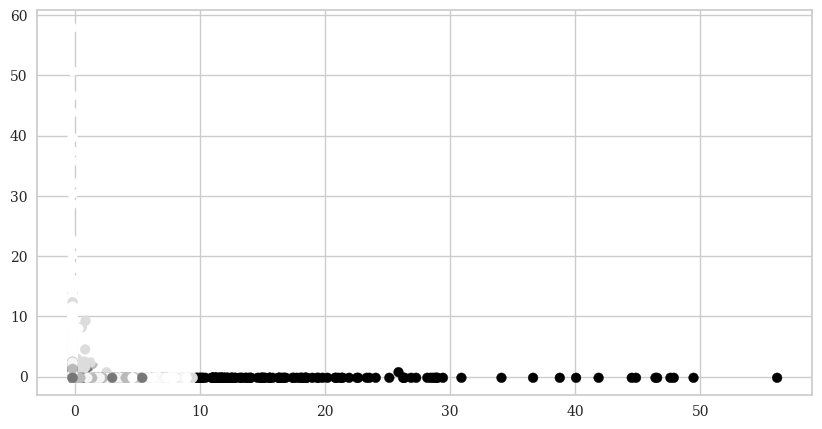

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x=df_kmean_segmentation.iloc[:, 1],
            y=df_kmean_segmentation.iloc[:, 2], c=kmeans_segmentation.labels_)

### K-mean (avec ACP)

#### ACP Transformation 

In [ ]:
acp = PCA(random_state=42)
acp.fit(kmeans_features)

PCA(random_state=42)

In [ ]:
acp.explained_variance_ratio_
explained_variance_ratio = acp.explained_variance_ratio_

([<matplotlib.axis.XTick at 0x78b354dc99a0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13')])

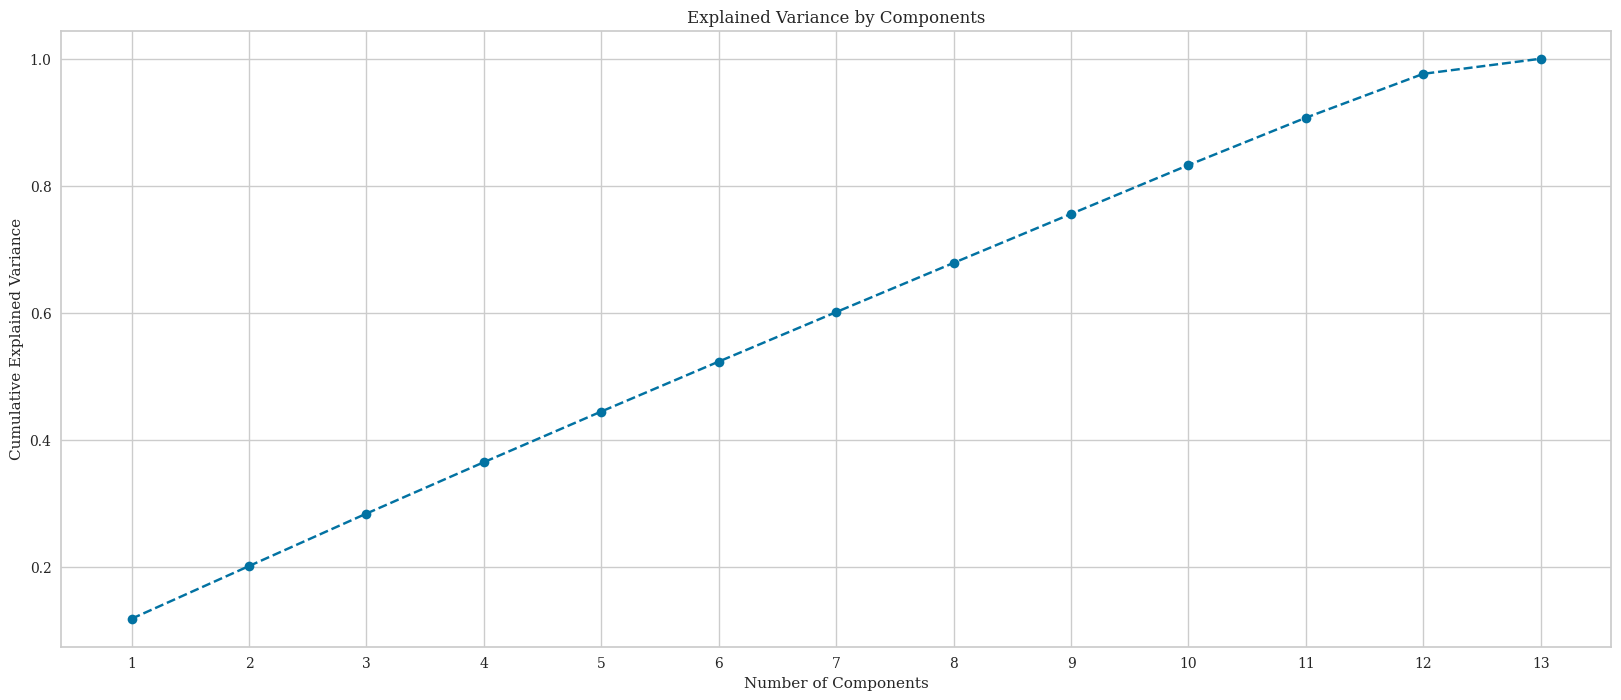

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio.cumsum(),
         marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))

10 composent explique 80% de la variance 

In [ ]:
# Choose number of component ACP
acp = PCA(n_components=2)
# fit data with ACP
acp.fit(kmeans_features)
components = acp.components_

In [ ]:
score_acp_k_means = acp.transform(kmeans_features)

In [ ]:
# Application du K-Means sur les données transformées par l'ACP
kmeans_with_acp = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_with_acp.fit(score_acp_k_means)

KMeans(n_clusters=14, random_state=42)

In [ ]:
# Create a new Dataframe to result of ACP
df_segment_acp_kmeans = pd.concat([kmeans_features.reset_index(
    drop=True), pd.DataFrame(score_acp_k_means)], axis=1)
df_segment_acp_kmeans.columns.values[-2:] = ['component_1', 'component_2']
df_segment_acp_kmeans["segment_kmeans_acp"] = kmeans_with_acp.labels_
df_kmean_segmentation = df_kmean_segmentation.reset_index(drop=True)
df_segment_acp_kmeans = df_segment_acp_kmeans.reset_index(drop=True)
# Add result to Principal Dataframe
df_kmean_segmentation['component_1'] = df_segment_acp_kmeans['component_1']
df_kmean_segmentation['component_2'] = df_segment_acp_kmeans['component_2']
df_kmean_segmentation['segment_kmeans_acp'] = df_segment_acp_kmeans['segment_kmeans_acp']


df_kmean_segmentation.head()

,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score,component_1,component_2,segment_kmeans_acp
0,0.509722,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,-0.829066,-0.162673,0.020830,5,0.572925,0.79598,19875.669707,-0.138803,0.612727,13
1,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,0.067001,-0.078251,-0.051336,-0.02455,-0.809404,-0.162673,-0.801986,5,0.572925,0.79598,19875.669707,-0.862559,-0.033426,8
2,-0.263807,-0.171268,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,1.962945,-0.162673,-0.430607,8,0.572925,0.79598,19875.669707,-0.739377,-0.152447,8
3,-0.263807,0.160607,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.547278,-0.162673,-0.749430,1,0.572925,0.79598,19875.669707,-0.856788,-0.095447,8
4,-0.263807,1.326736,-0.20043,-0.24093,-0.059443,-0.151745,-0.235404,-0.078251,-0.051336,-0.02455,0.330995,-0.162673,0.392209,1,0.572925,0.79598,19875.669707,0.238824,-0.396328,1


In [ ]:
mapping = {
    0: 'premier',
    1: 'deuxième',
    2: 'troisième',
    3: 'quatrième',
    4: 'cinquième',
    5: 'sixième',
    6: 'septième',
    7: 'huitième',
    8: 'neuvième',
    9: 'dixième',
    10: 'onzième',
    11: 'douzième',
    12: 'treizième',
    13: 'quatorzième'
}

# Application du mapping pour créer la colonne 'segment'
df_segment_acp_kmeans['segment'] = df_segment_acp_kmeans['segment_kmeans_acp'].map(
    mapping)

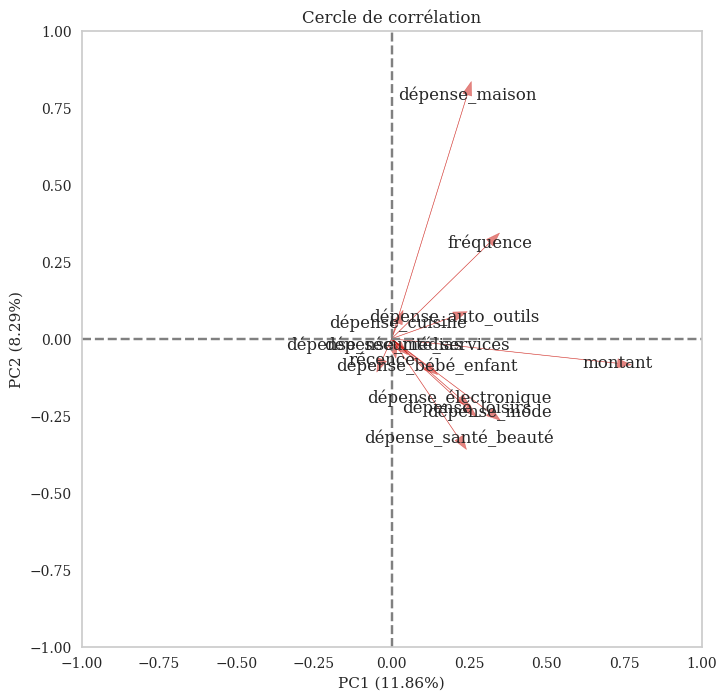

In [ ]:
# Plot du cercle de corrélation
def correlation_circle(components, labels, acp):
    plt.figure(figsize=(8, 8))
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    for i, (component_1, component_2) in enumerate(components.T[:, :2]):
        plt.arrow(0, 0, component_1, component_2,
                  color='r', alpha=0.5, head_width=0.03)
        plt.text(component_1, component_2, labels[i],
                 fontsize=12, ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC1 ({acp.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({acp.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title('Cercle de corrélation')
    plt.grid()
    plt.show()


# Noms des colonnes pour les étiquettes
labels = kmeans_features.columns

# Création du cercle de corrélation
correlation_circle(components, labels, acp)

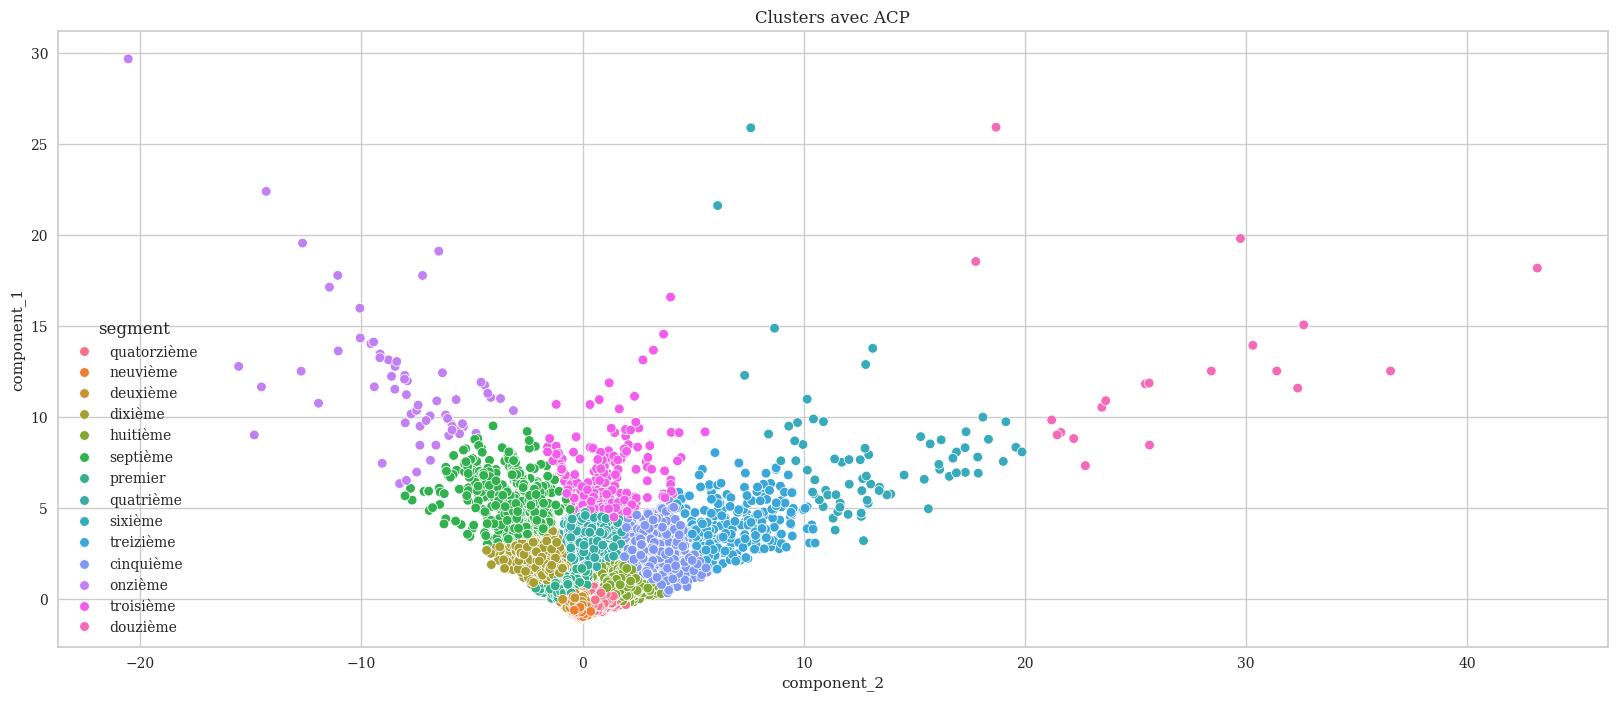

In [ ]:
# Plot data by PCA component
x_axis = df_segment_acp_kmeans['component_2']
y_axis = df_segment_acp_kmeans['component_1']
plt.figure(figsize=(20, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segment_acp_kmeans['segment'])
plt.title('Clusters avec ACP')
plt.show()

### K-means (avec TSNE)

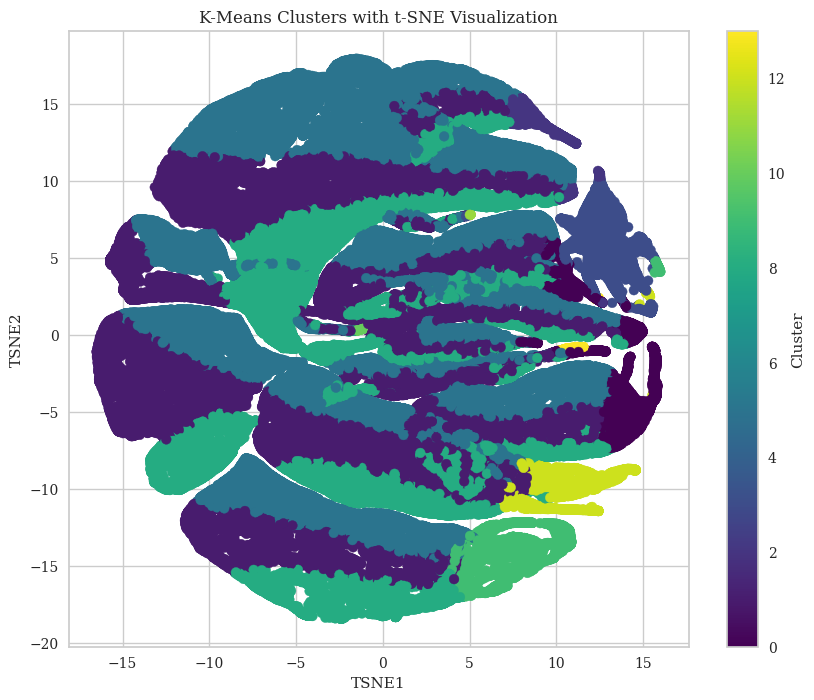

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_kmean_segmentation['Cluster_TSNE'] = kmeans.fit_predict(kmeans_features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(kmeans_features)

# Add t-SNE results to the DataFrame
df_kmean_segmentation['TSNE1'] = tsne_results[:, 0]
df_kmean_segmentation['TSNE2'] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_kmean_segmentation['TSNE1'], df_kmean_segmentation['TSNE2'],
            c=df_kmean_segmentation['Cluster_TSNE'], cmap='viridis')
plt.title('K-Means Clusters with t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
display(df_kmean_segmentation)

NameError: name 'df_kmean_segmentation' is not defined

## K-prototypes

In [68]:
# Preprocess the data
categorical_columns = ['type_de_paiement_préféré', 'ville_client',
                       'état_client', 'jour_avec_plus_de_commandes', 'catégorie_préférée']
numerical_columns = df_segmentation.columns.difference(categorical_columns).tolist()

for col in categorical_columns:
    df_segmentation[col] = df_segmentation[col].astype('category')

df_segmentation_kprototype = df_segmentation[categorical_columns +
                                             numerical_columns].copy()

# Convert categorical columns to their codes
for col in categorical_columns:
    df_segmentation_kprototype[col] = df_segmentation_kprototype[col].cat.codes

# Get the indices of categorical columns
categorical_indices = [df_segmentation_kprototype.columns.get_loc(
    col) for col in categorical_columns]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 27318, ncost: 1354137.949308431
Run: 1, iteration: 2/100, moves: 6876, ncost: 1352220.1014947975
Run: 1, iteration: 3/100, moves: 1464, ncost: 1351981.5222749014
Run: 1, iteration: 4/100, moves: 451, ncost: 1351958.5699627525
Run: 1, iteration: 5/100, moves: 130, ncost: 1351956.077921931
Run: 1, iteration: 6/100, moves: 74, ncost: 1351953.95061192
Run: 1, iteration: 7/100, moves: 142, ncost: 1351948.5010857414
Run: 1, iteration: 8/100, moves: 128, ncost: 1351946.6441701492
Run: 1, iteration: 9/100, moves: 80, ncost: 1351946.178851264
Run: 1, iteration: 10/100, moves: 57, ncost: 1351945.5673436422
Run: 1, iteration: 11/100, moves: 61, ncost: 1351944.5366288933
Run: 1, iteration: 12/100, moves: 47, ncost: 1351944.3748731094
Run: 1, iteration: 13/100, moves: 23, ncost: 1351944.345580239
Run: 1, iteration: 14/100, moves: 7, ncost: 1351944.343193696
Run: 1, iteration: 15/100, mov

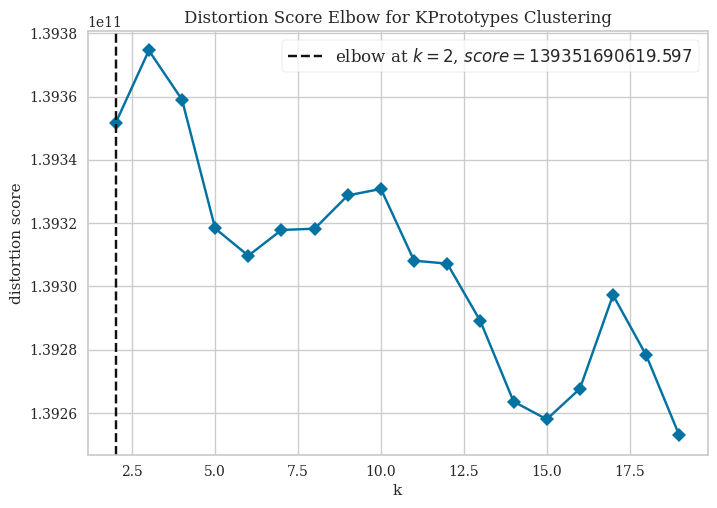

Optimal number of clusters: 2


In [69]:
# Use KElbowVisualizer to find the optimal number of clusters

model = KPrototypes(random_state=42, init='Huang', n_init=1, verbose=1)
visualizer = KElbowVisualizer(
    model, k=(2, 20), metric='distortion', timings=False)
visualizer.fit(df_segmentation_kprototype, categorical=categorical_indices)
visualizer.show()


# Determine the optimal number of clusters
optimal_clusters = visualizer.elbow_value_
print(f'Optimal number of clusters: {optimal_clusters}')

In [71]:
# Apply K-Prototypes clustering with the optimal number of clusters
kproto = KPrototypes(n_clusters=optimal_clusters, random_state=42)
clusters = kproto.fit_predict(
    df_segmentation_kprototype, categorical=categorical_indices)

# Assign cluster labels to the dataframe
df_segmentation_kprototype['Cluster_kproto'] = kproto.labels_


# Ensure data is in numeric format for score calculations
df_numeric = df_segmentation_kprototype.drop(columns=categorical_columns)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Calculate Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Calculate Davies-Bouldin Score
davies_bouldin_avg = davies_bouldin_score(
    df_numeric, df_segmentation_kprototype['Cluster_kproto'])

# Add these scores to the DataFrame
df_segmentation_kprototype['Silhouette_Score'] = silhouette_avg
df_segmentation_kprototype['Calinski_Harabasz_Score'] = calinski_harabasz_avg
df_segmentation_kprototype['Davies_Bouldin_Score'] = davies_bouldin_avg

KeyboardInterrupt: 

In [70]:
display(df_segmentation_kprototype)

,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_auto_outils,dépense_bébé_enfant,dépense_cuisine,dépense_loisirs,dépense_maison,dépense_mode,dépense_médias,dépense_santé_beauté,dépense_sécurité_services,dépense_électronique,fréquence,montant,récence
identifiant_client,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,648,25,1,7,-0.105316,-0.077747,-0.016793,-0.206984,0.341400,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.074179,-0.825585
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2571,25,2,43,-0.105316,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,0.034744,-0.008695,-0.066068,-0.200448,-0.574410,-0.805902
0000f46a3911fa3c0805444483337064,1,3486,23,6,66,-0.105316,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.348630,1.969343
0000f6ccb0745a6a4b88665a16c9f078,1,444,13,1,68,-0.105316,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,0.023856,-0.200448,-0.542459,0.552197
0004aac84e0df4da2b147fca70cf8255,1,3724,25,3,68,-0.105316,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,0.339829,-0.200448,0.151602,0.335688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,3226,15,1,43,-0.105316,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,35.908899,-0.008695,-0.066068,-0.200448,6.415765,1.378865
fffea47cd6d3cc0a88bd621562a9d061,1,1313,4,0,6,-0.105316,1.063409,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.367152,0.165106
ffff371b4d645b6ecea244b27531430a,1,3706,12,3,5,0.397593,-0.077747,-0.016793,-0.206984,-0.217053,-0.162143,-0.058154,-0.202720,-0.008695,-0.066068,-0.200448,-0.254442,2.172730


### Visualisation PCA


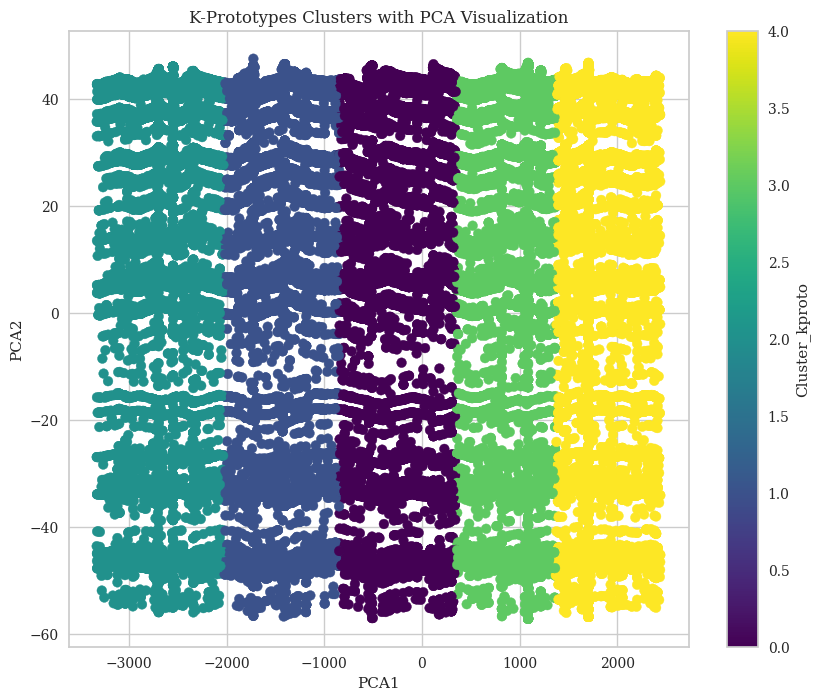

In [ ]:
# Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_segmentation_kprototype)

df_segmentation_kprototype['PCA1'] = pca_results[:, 0]
df_segmentation_kprototype['PCA2'] = pca_results[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(df_segmentation_kprototype['PCA1'], df_segmentation_kprototype['PCA2'],
            c=df_segmentation_kprototype['Cluster_kproto'], cmap='viridis')
plt.title('K-Prototypes Clusters with PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster_kproto')
plt.show()

### Visualisation TSNE

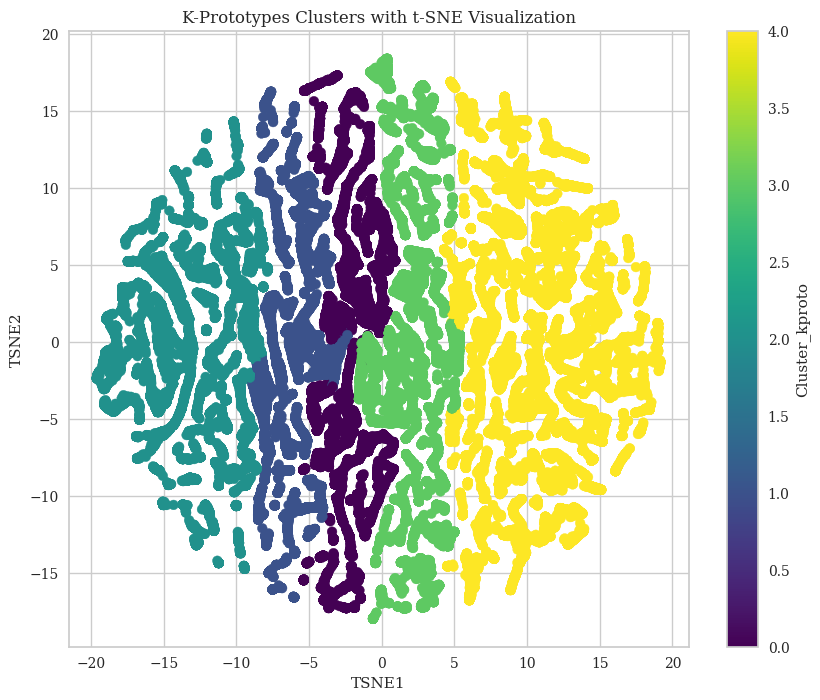

In [ ]:
# Visualize Clusters with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(df_segmentation_kprototype)

df_segmentation_kprototype['TSNE1'] = tsne_results[:, 0]
df_segmentation_kprototype['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(df_segmentation_kprototype['TSNE1'], df_segmentation_kprototype['TSNE2'],
            c=df_segmentation_kprototype['Cluster_kproto'], cmap='viridis')
plt.title('K-Prototypes Clusters with t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster_kproto')
plt.show()

## Segmentation RFM analyse clustering

In [7]:
# Merge two dataframe for add Cluster_Label columns
df_without_preprocessing = pd.read_csv('df_cleaning.csv')
df_without_preprocessing.set_index('identifiant_client')

df1_reset = df_without_preprocessing.reset_index()
df2_reset = df_kmean_segmentation.reset_index()

df_with_cluster = pd.merge(df1_reset, df2_reset[[
                           'identifiant_client', 'Cluster_Label']], on='identifiant_client', how='left')


df_with_cluster.set_index('identifiant_client', inplace=True)


display(df_with_cluster.head())

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label
identifiant_client,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,0.00,0.0,0.0,0.0,0.0,27.19,0.0,0.0,0.0,5
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,8
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,43.62,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,196.89,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1


### Création du Segment RFM

In [8]:
df_with_cluster["récence_score"] = pd.qcut(
    df_with_cluster['récence'], 5, labels=[5, 4, 3, 2, 1])
df_with_cluster["fréquence_score"] = pd.qcut(
    df_with_cluster['fréquence'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_with_cluster["montant_score"] = pd.qcut(
    df_with_cluster['montant'], 5, labels=[1, 2, 3, 4, 5])

In [9]:
df_with_cluster['RFM_SCORE'] = df_with_cluster.récence_score.astype(
    str) + df_with_cluster.fréquence_score.astype(str) + df_with_cluster.montant_score.astype(str)
df_with_cluster

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.00,0.00,0.0,0.0,5,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,0.00,27.19,0.00,0.0,0.0,5,4,1,1,411
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.00,0.00,0.0,0.0,8,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,1,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,1,2,1,5,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,92342,245.0,1,149.00,credit_card,fortaleza,CE,Mercredi,bed_bath_table,149.0,...,0.00,0.00,0.00,0.0,0.0,1,3,5,4,354
fffea47cd6d3cc0a88bd621562a9d061,92343,262.0,1,64.89,credit_card,feira de santana,BA,Dimanche,baby,0.0,...,0.00,0.00,84.58,0.0,0.0,1,3,5,2,352
ffff371b4d645b6ecea244b27531430a,92344,568.0,1,89.90,credit_card,sinop,MT,Mardi,auto,0.0,...,112.46,0.00,0.00,0.0,0.0,8,1,5,3,153


In [10]:
seg_map = {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [11]:
df_with_cluster['Segment'] = df_with_cluster['récence_score'].astype(
    str) + df_with_cluster['fréquence_score'].astype(str) + df_with_cluster['montant_score'].astype(str)
df_with_cluster['Segment'] = df_with_cluster['Segment'].replace(
    seg_map, regex=True)
df_with_cluster.head()

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE,Segment
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.0,0.0,0.0,5,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,27.19,0.0,0.0,0.0,5,4,1,1,411,New Customers
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.0,0.0,0.0,8,1,1,2,112,Lost customers
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.0,0.0,0.0,1,2,1,1,211,Hibernating customers
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.0,0.0,0.0,1,2,1,5,215,Cannot Lose Them


### Analyse RFM sans clusters

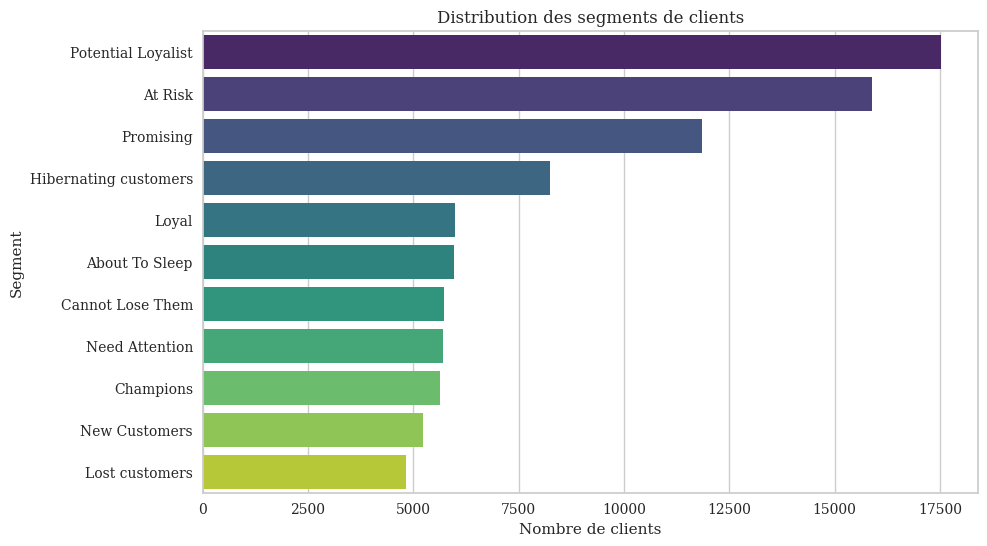

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the countplot, ordering by the frequency of each segment
sns.countplot(y='Segment', data=df_with_cluster,
              order=df_with_cluster['Segment'].value_counts().index, palette='viridis')

# Set the title and labels
plt.title('Distribution des segments de clients')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')

# Display the plot
plt.show()

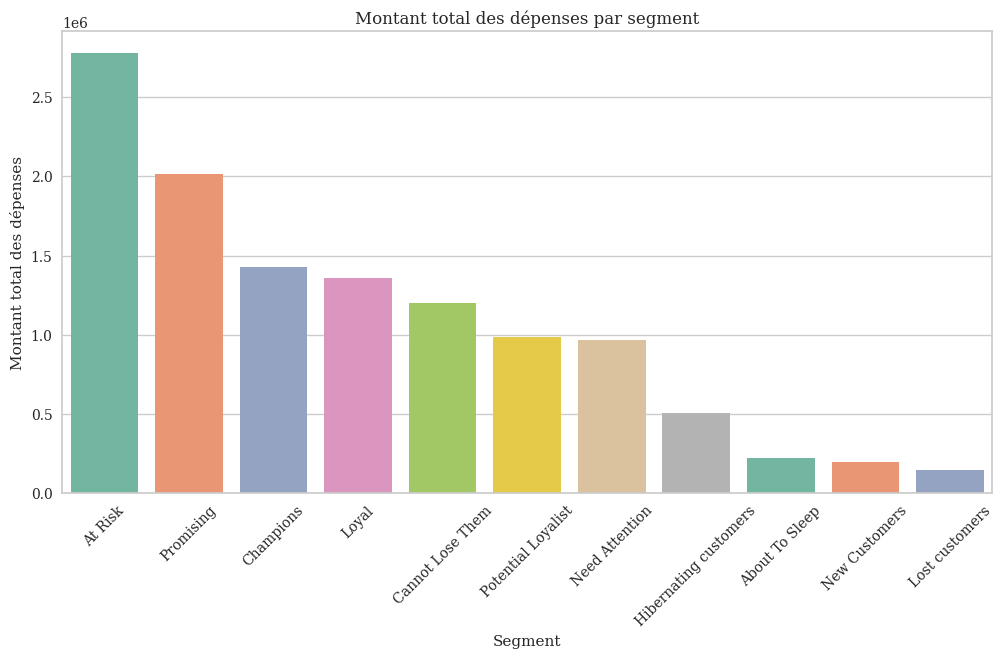

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='montant', data=df_with_cluster, palette='Set2', estimator=sum, ci=None,
            order=df_with_cluster.groupby('Segment')['montant'].sum().sort_values(ascending=False).index)
plt.title('Montant total des dépenses par segment')
plt.xlabel('Segment')
plt.ylabel('Montant total des dépenses')
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Créer un DataFrame pour les segments et leurs comptes
df_treemap = df_with_cluster['Segment'].value_counts().reset_index()
df_treemap.columns = ['Segment', 'Count']

# Créer le treemap avec Plotly
fig = px.treemap(df_treemap,
                 path=['Segment'],
                 values='Count',
                 color='Count',  # Optionnel, pour ajouter des couleurs basées sur le compte
                 # Vous pouvez choisir la palette de couleurs que vous préférez
                 color_continuous_scale='RdYlGn',
                 title='Treemap des segments de clients')

# Afficher le treemap
fig.show()

### Analyse des segments clients avec les clusters (13 cluster kmeans)

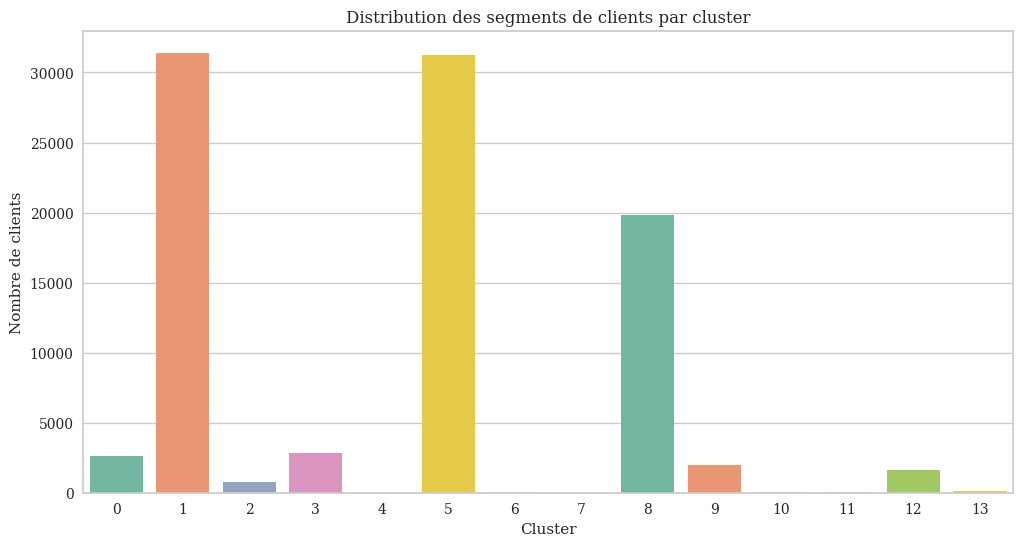

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_with_cluster, x='Cluster_Label', palette='Set2')
plt.title('Distribution des segments de clients par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

In [19]:
# Filtrer le DataFrame pour les Cluster_Label spécifiques
filtered_clusters = df_with_cluster[df_with_cluster['Cluster_Label'].isin([
                                                                          4, 6, 7, 10, 11])]

# Compter le nombre de valeurs pour chaque Cluster_Label
cluster_counts = filtered_clusters['Cluster_Label'].value_counts()

# Afficher les résultats
print(cluster_counts)

Cluster_Label
10    69
11    41
6     24
4      4
7      1
Name: count, dtype: int64


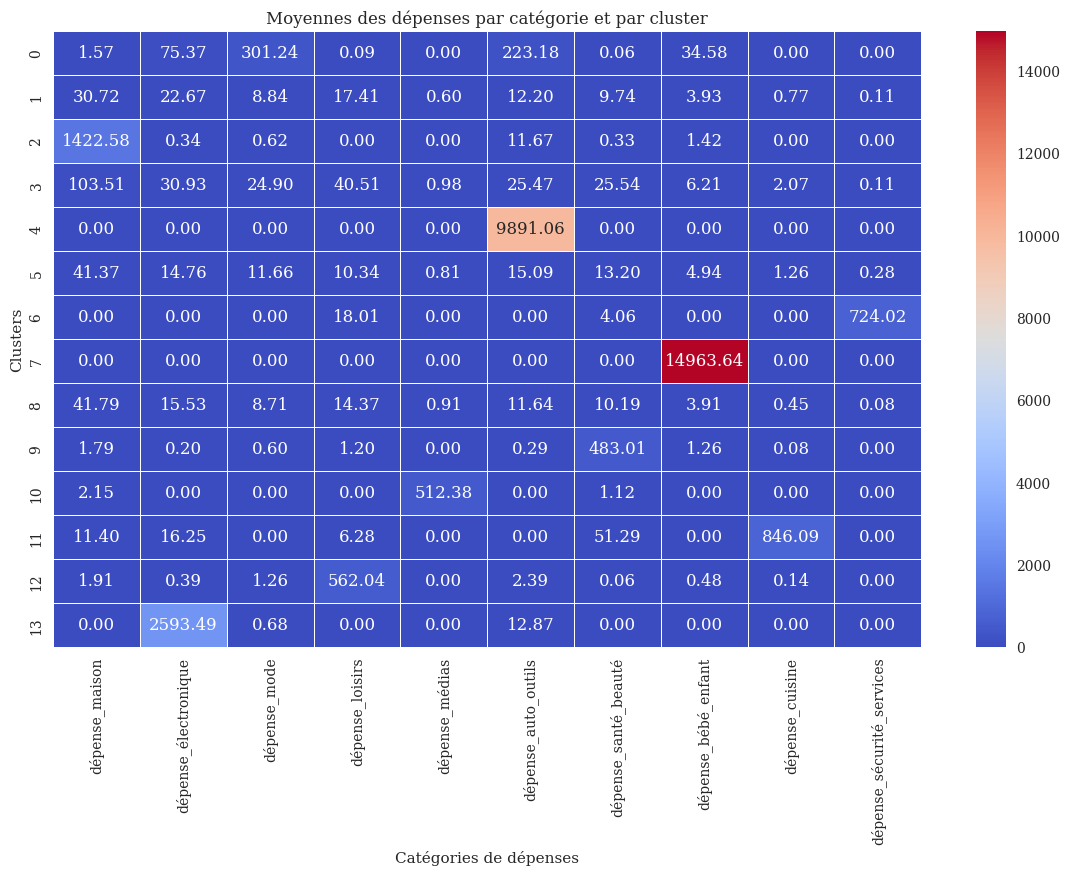

In [24]:
# Filtrer les colonnes numériques seulement pour le calcul des moyennes
numeric_cols = df_with_cluster.select_dtypes(include=['number']).columns

# Calculer la moyenne des dépenses par catégorie pour chaque cluster
depense_par_cluster = df_with_cluster.groupby(
    'Cluster_Label')[numeric_cols].mean().filter(like='dépense')

# Créer une heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(depense_par_cluster, annot=True,
            fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Moyennes des dépenses par catégorie et par cluster')
plt.xlabel('Catégories de dépenses')
plt.ylabel('Clusters')
plt.show()

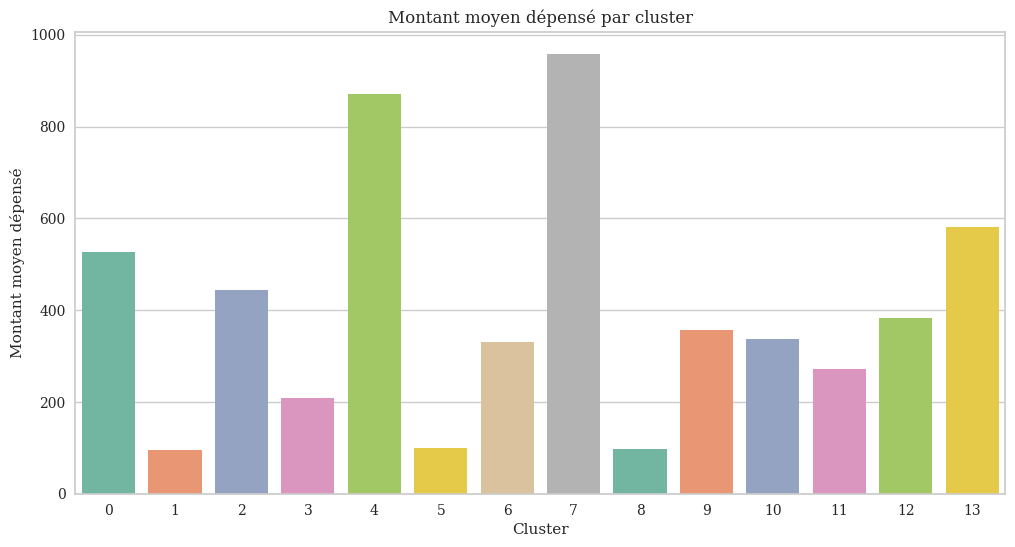

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_with_cluster, x='Cluster_Label',
            y='montant', palette='Set2', ci=None)
plt.title('Montant moyen dépensé par cluster')
plt.xlabel('Cluster')
plt.ylabel('Montant moyen dépensé')
plt.show()

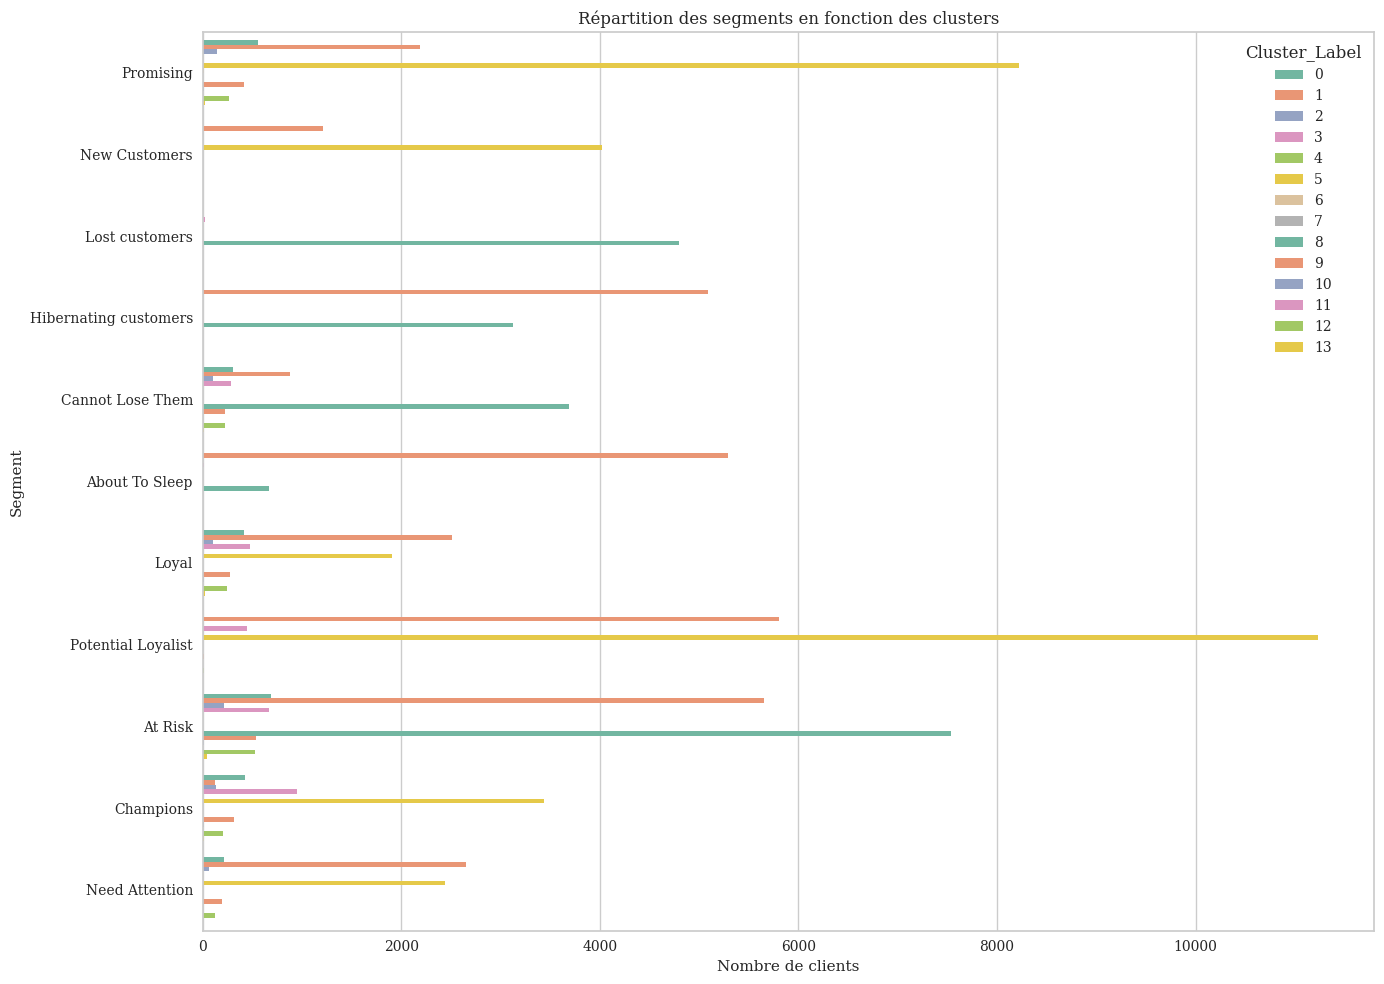

In [16]:
# Augmenter la taille de la figure pour un affichage horizontal
plt.figure(figsize=(14, 10))
sns.countplot(data=df_with_cluster, y='Segment',
              hue='Cluster_Label', palette='Set2',)

plt.title('Répartition des segments en fonction des clusters')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')

# Ajuster les espacements
plt.tight_layout()

plt.show()

### Conclusion Analyse segmentation par cluster

#### Analyse marketing

Voici une analyse des clusters identifiés avec des propositions d'actions marketing spécifiques pour chacun :

 1. **Cluster 0**
   - **Caractéristiques :** Taille moyenne avec des dépenses modérées et diversifiées, notamment en "dépense_maison" et "dépense_électronique".
   - **Proposition Marketing :**
     - **Campagnes de Cross-Selling :** Proposer des produits complémentaires dans les catégories "maison" et "électronique".
     - **Programme de Fidélité :** Offrir des avantages sur les achats récurrents pour inciter à plus de dépenses régulières.
     

 2. **Cluster 1**
   - **Caractéristiques :** Le plus grand cluster avec des dépenses faibles à modérées. Majorité des clients sont des "New Customers" ou "At Risk".
   - **Proposition Marketing :**
     - **Campagnes de Bienvenue :** Envoyer des messages de bienvenue personnalisés pour les nouveaux clients, avec des offres de découverte.
     - **Réengagement des Clients à Risque :** Utiliser des réductions, cadeaux pour réengager les clients qui montrent des signes de désengagement.


 3. **Cluster 2**
   - **Caractéristiques :** Petit cluster avec des dépenses concentrées sur l'électronique.
   - **Proposition Marketing :**
     - **Campagnes ciblées sur l'Électronique :** Promouvoir des offres spéciales sur des produits électroniques.
     - **Newsletter Spécifique :** Créer une newsletter dédiée aux nouveautés technologiques pour capter l'intérêt de ce segment.


 4. **Cluster 3**
   - **Caractéristiques :** Dépenses variées avec une concentration sur la santé et la beauté. Majorité des clients sont des "Hibernating Customers".
   - **Proposition Marketing :**
     - **Campagnes de Réactivation :** Relancer ces clients avec des offres personnalisées dans les catégories où ils ont déjà dépensé.
     - **Promotion des Nouveautés :** Mettre en avant les nouveaux produits dans les catégories "santé" et "beauté" pour susciter l'intérêt.


 5. **Cluster 4**
   - **Caractéristiques :** Très forte dépense en "dépense_maison" avec un montant moyen dépensé élevé. Comprend principalement des "Cannot Lose Them" et "Champions".
   - **Proposition Marketing :**
     - **Programme VIP :** Créer un programme de fidélité exclusif pour récompenser ces clients fidèles et de haute valeur.
     - **Services Personnalisés :** Offrir des consultations ou des services personnalisés pour les achats liés à la maison.
     - **Accès Prioritaire :** Donner à ces clients un accès anticipé aux nouvelles collections ou aux ventes privées.

 6. **Cluster 5**
   - **Caractéristiques :** Deuxième plus grand cluster avec des dépenses variées mais modérées. Majorité des clients sont des "Potential Loyalist" et "New Customers".
   - **Proposition Marketing :**
     - **Stratégies de Renforcement de la Loyauté :** Offrir des points bonus ou des réductions pour les achats répétés.
     - **Optimisation des Parcours d’Achat :** Simplifier le processus d'achat pour les nouveaux clients afin d'encourager leur retour.


 7. **Cluster 6**
   - **Caractéristiques :** Petit cluster avec une dépense élevée en "dépense_auto_outils". Clientèle de niche.
   - **Proposition Marketing :**
     - **Campagnes Spécialisées :** Créer des campagnes ciblées pour les amateurs d'automobile ou de bricolage.


 8. **Cluster 7**
   - **Caractéristiques :** Très fortes dépenses en "dépense_bébé_enfant" avec le montant moyen dépensé le plus élevé.
   - **Proposition Marketing :**
     - **Programme de Fidélité Familial :** Offrir un programme de fidélité spécifique aux familles, avec des avantages sur les produits pour enfants.
     - **Partenariats avec des Marques pour Enfants :** Collaborer avec des marques reconnues pour enfants pour offrir des produits exclusifs.

 9. **Cluster 8**
   - **Caractéristiques :** Troisième plus grand cluster avec des dépenses diversifiées mais modérées.
   - **Proposition Marketing :**
     - **Stratégies de Réactivation :** Cibler les clients en hibernation avec des offres attractives pour les inciter à acheter de nouveau.
     - **Offres Temporisées :** Créer un sentiment d'urgence avec des offres limitées dans le temps pour stimuler les achats.


 10. **Cluster 9**
   - **Caractéristiques :** Petit cluster avec des dépenses concentrées sur la santé et la beauté.
   - **Proposition Marketing :**
     - **Programme de Récompense pour la Beauté :** Introduire un programme de récompenses pour encourager les achats répétés dans cette catégorie.
     - **Partenariats Beauté :** Collaborer avec des marques de santé pour offrir des produits ou services complémentaires.

 11. **Cluster 10**
   - **Caractéristiques :** Dépenses concentrées sur "dépense_bébé_enfant" et "dépense_sécurité_services".
   - **Proposition Marketing :**
     - **Offres pour les Familles :** Promouvoir des produits de sécurités ainsi que dépenses pour les enfants en partenariat avec des marques spécialisées.



 12. **Cluster 11**
   - **Caractéristiques :** Dépenses équilibrées mais faibles. Majorité des clients sont en hibernation ou dans le segment "Cannot Lose Them".
   - **Proposition Marketing :**
     - **Campagnes de Réactivation Intense :** Envoyer des offres personnalisées pour les inciter à revenir.
     - **Offres de Relance :** Proposer des offres spéciales pour encourager des achats impulsifs.

 13. **Cluster 12**
   - **Caractéristiques :** Petit cluster avec des dépenses équilibrées mais faibles, avec une majorité de clients à risque.
   - **Proposition Marketing :**
     - **Stratégies de Réengagement :** Offrir des incentives pour réengager les clients à risque.
     - **Feedback Client :** Demander un feedback aux clients pour comprendre pourquoi ils sont devenus moins actifs et ajuster les offres en conséquence.

 14. **Cluster 13**
   - **Caractéristiques :** Dépenses élevées en "dépense_électronique", avec un montant moyen dépensé élevé. Comprend des "Champions" et des "Potential Loyalist".
   - **Proposition Marketing :**
     - **Lancement de Nouveaux Produits :** Proposer en avant-première les nouveautés en électronique à ce cluster.
     - **Programmes de Récompense Premium :** Offrir des programmes de récompenses haut de gamme pour maintenir et renforcer la loyauté.

### Interprétation modèle k-mean avec 13 cluster 

- Un nombre trop important que cluster pour une analyse marketing de la segmentation
- Un bais dans le choix des features au niveau des dépenses par catégories qui détermine les clusters trop en fonction de cela

- Test d'un nouveau modèle en supprimant des features

## Test Kmeans avec suppresssion de certaines Features

### K-mean

In [73]:
# Create dataframe for kmeans model and evaluation
# Keep only numerical for kmeans
# keep only 'récence', 'fréquence', 'montant'
other_columns = ['récence', 'fréquence', 'montant']

# Merge all columns selected to a new dataframe
df_kmean_new = df_segmentation[other_columns]
df_kmean_new.head()

,récence,fréquence,montant
identifiant_client,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.825585,-0.200448,-0.074179
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.805902,-0.200448,-0.574410
0000f46a3911fa3c0805444483337064,1.969343,-0.200448,-0.348630
0000f6ccb0745a6a4b88665a16c9f078,0.552197,-0.200448,-0.542459
0004aac84e0df4da2b147fca70cf8255,0.335688,-0.200448,0.151602


### Recherche du meilleur nombres de clusters

#### Elbow

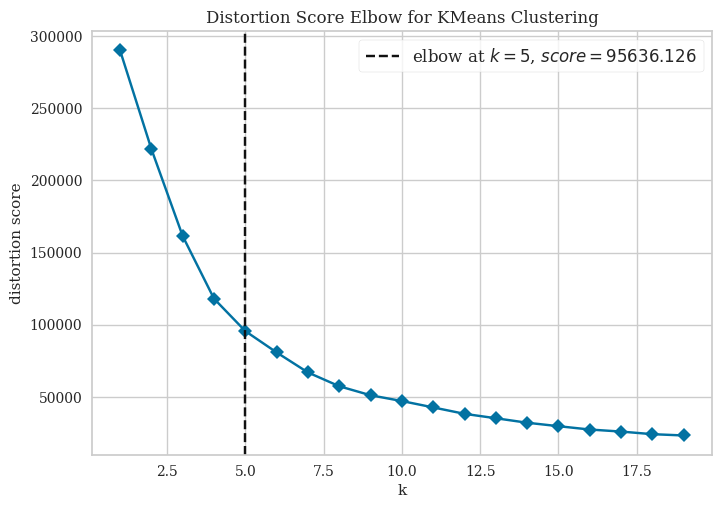

In [74]:

# Instantiate the clustering model and visualizer
model = KMeans(max_iter=500, n_init=10, random_state=42)
# Visualize the optimal number of clusters kmeans
visualizer = KElbowVisualizer(model, k=(1, 20), timings=False)
visualizer.fit(df_kmean_new)
visualizer.show()
# Capture the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

#### Silhouette Score

In [75]:
silhouette_scores = []
for n_clusters in range(2, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    print(f"Calculating Silhouette score for {n_clusters} clusters...")
    cluster_labels = kmeans.fit_predict(df_kmean_new)
    silhouette_avg = silhouette_score(df_kmean_new, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Convert to DataFrame for easier viewing
silhouette_df = pd.DataFrame(silhouette_scores, columns=[
                             'n_clusters', 'silhouette_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_silhouette = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax(
)]

print("Best Silhouette Score:")
print(best_n_clusters_silhouette)

Calculating Silhouette score for 2 clusters...


Calculating Silhouette score for 3 clusters...
Calculating Silhouette score for 4 clusters...
Calculating Silhouette score for 5 clusters...
Calculating Silhouette score for 6 clusters...
Calculating Silhouette score for 7 clusters...
Calculating Silhouette score for 8 clusters...
Calculating Silhouette score for 9 clusters...
Calculating Silhouette score for 10 clusters...
Calculating Silhouette score for 11 clusters...
Calculating Silhouette score for 12 clusters...
Calculating Silhouette score for 13 clusters...
Calculating Silhouette score for 14 clusters...
Calculating Silhouette score for 15 clusters...
Calculating Silhouette score for 16 clusters...
Calculating Silhouette score for 17 clusters...
Calculating Silhouette score for 18 clusters...
Calculating Silhouette score for 19 clusters...
Calculating Silhouette score for 20 clusters...
Best Silhouette Score:
n_clusters          2.000000
silhouette_score    0.627792
Name: 0, dtype: float64


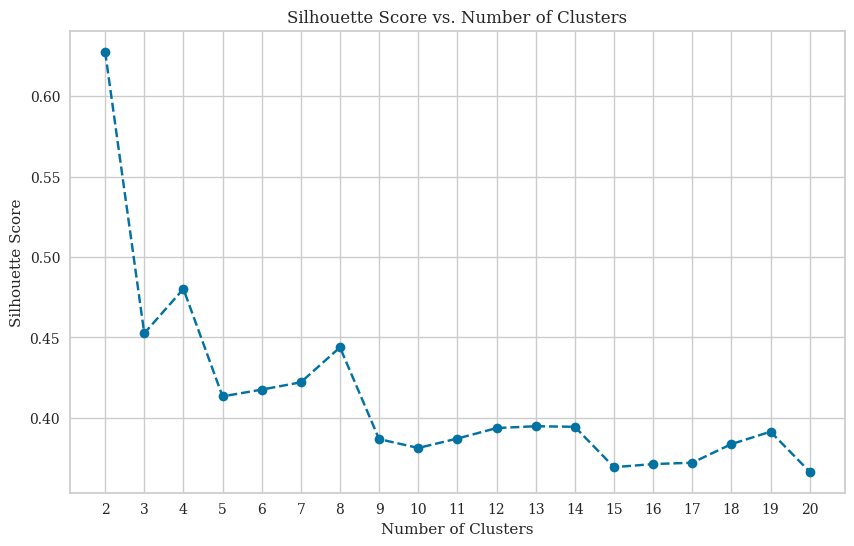

In [80]:
# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(silhouette_df['n_clusters'],
         silhouette_df['silhouette_score'], marker='o', linestyle='--')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [76]:

davies_bouldin_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating Davies-Bouldin score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_new)
    db_score = davies_bouldin_score(df_kmean_new, cluster_labels)
    davies_bouldin_scores.append((n_clusters, db_score))

# Convert to DataFrame for easier viewing
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=[
                                 'n_clusters', 'davies_bouldin_score'])

# Find the best score and corresponding number of clusters (lowest score is better)
best_n_clusters_davies_bouldin = davies_bouldin_df.loc[davies_bouldin_df['davies_bouldin_score'].idxmin(
)]

print("Best Davies-Bouldin Index:")
print(best_n_clusters_davies_bouldin)

Calculating Davies-Bouldin score for 2 clusters...
Calculating Davies-Bouldin score for 3 clusters...
Calculating Davies-Bouldin score for 4 clusters...
Calculating Davies-Bouldin score for 5 clusters...


Calculating Davies-Bouldin score for 6 clusters...
Calculating Davies-Bouldin score for 7 clusters...
Calculating Davies-Bouldin score for 8 clusters...
Calculating Davies-Bouldin score for 9 clusters...
Calculating Davies-Bouldin score for 10 clusters...
Calculating Davies-Bouldin score for 11 clusters...
Calculating Davies-Bouldin score for 12 clusters...
Calculating Davies-Bouldin score for 13 clusters...
Calculating Davies-Bouldin score for 14 clusters...
Calculating Davies-Bouldin score for 15 clusters...
Calculating Davies-Bouldin score for 16 clusters...
Calculating Davies-Bouldin score for 17 clusters...
Calculating Davies-Bouldin score for 18 clusters...
Calculating Davies-Bouldin score for 19 clusters...
Calculating Davies-Bouldin score for 20 clusters...
Best Davies-Bouldin Index:
n_clusters              18.000000
davies_bouldin_score     0.707804
Name: 16, dtype: float64


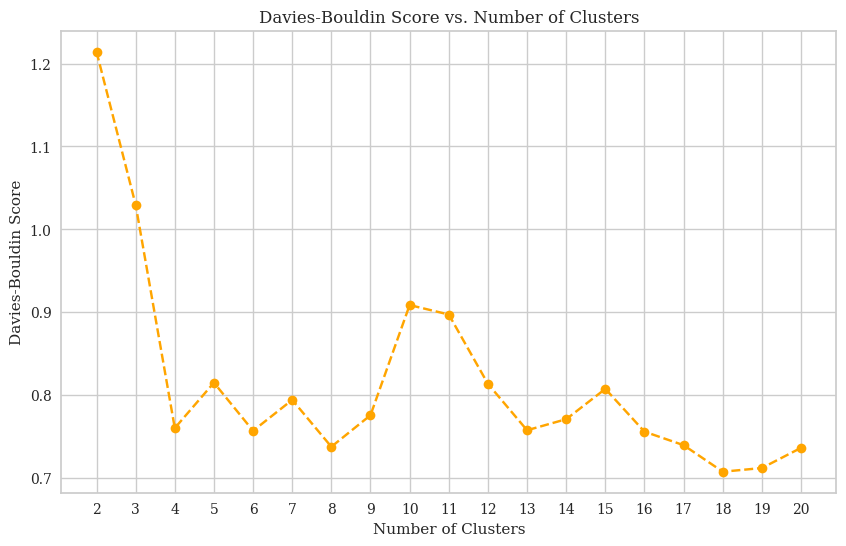

In [77]:
# Plotting Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(davies_bouldin_df['n_clusters'], davies_bouldin_df['davies_bouldin_score'],
         marker='o', linestyle='--', color='orange')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

In [78]:
calinski_harabasz_scores = []

for n_clusters in range(2, 21):
    print(f"Calculating calinski harabasz score for {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_kmean_new)
    ch_score = calinski_harabasz_score(df_kmean_new, cluster_labels)
    calinski_harabasz_scores.append((n_clusters, ch_score))

# Convert to DataFrame for easier viewing
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=[
                                    'n_clusters', 'calinski_harabasz_score'])

# Find the best score and corresponding number of clusters
best_n_clusters_calinski_harabasz = calinski_harabasz_df.loc[
    calinski_harabasz_df['calinski_harabasz_score'].idxmax()]

print("Best Calinski-Harabasz Index:")
print(best_n_clusters_calinski_harabasz)

Calculating calinski harabasz score for 2 clusters...
Calculating calinski harabasz score for 3 clusters...
Calculating calinski harabasz score for 4 clusters...
Calculating calinski harabasz score for 5 clusters...
Calculating calinski harabasz score for 6 clusters...
Calculating calinski harabasz score for 7 clusters...
Calculating calinski harabasz score for 8 clusters...
Calculating calinski harabasz score for 9 clusters...
Calculating calinski harabasz score for 10 clusters...
Calculating calinski harabasz score for 11 clusters...
Calculating calinski harabasz score for 12 clusters...
Calculating calinski harabasz score for 13 clusters...
Calculating calinski harabasz score for 14 clusters...
Calculating calinski harabasz score for 15 clusters...
Calculating calinski harabasz score for 16 clusters...
Calculating calinski harabasz score for 17 clusters...
Calculating calinski harabasz score for 18 clusters...
Calculating calinski harabasz score for 19 clusters...
Calculating calins

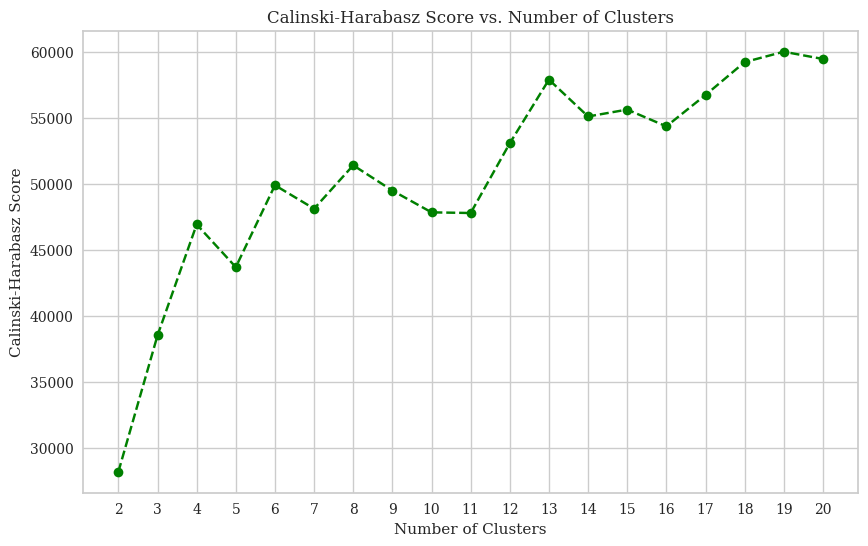

In [79]:
# Plotting Calinski-Harabasz Scores
plt.figure(figsize=(10, 6))
plt.plot(calinski_harabasz_df['n_clusters'], calinski_harabasz_df['calinski_harabasz_score'],
         marker='o', linestyle='--', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()

Avec les résultats suivi ont peut remarquer que le bon de clusters a choisir est 14

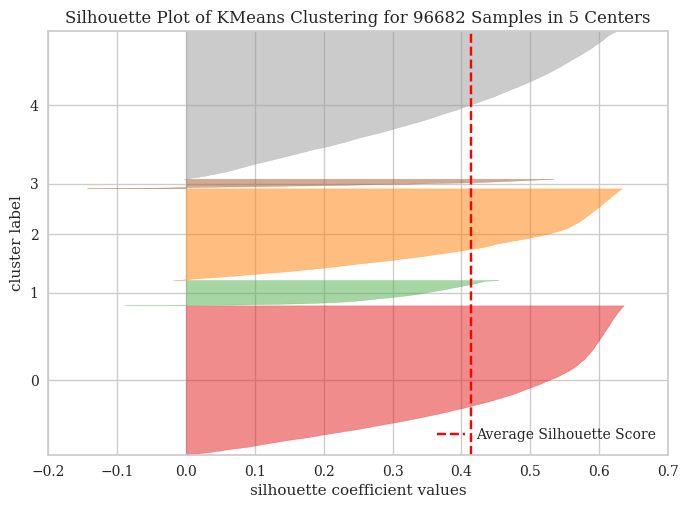

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96682 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [81]:
# Initialisation

# k-means with best cluster
kmeans_segmentation = KMeans(
    n_clusters=optimal_clusters, init='k-means++', random_state=42, max_iter=500)
# Fit the K-Means model and predict the cluster labels
df_kmean_new['Cluster_Label'] = kmeans_segmentation.fit_predict(
    df_kmean_new)

# Evaluation
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(
    df_kmean_new, df_kmean_new['Cluster_Label'])
df_kmean_new['Silhouette_Score'] = silhouette_avg

# Calculate the Davies-Bouldin Index
db_score = davies_bouldin_score(
    df_kmean_new, df_kmean_new['Cluster_Label'])
df_kmean_new['Davies_Bouldin_Score'] = db_score

# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(
    df_kmean_new, df_kmean_new['Cluster_Label'])
df_kmean_new['Calinski_Harabasz_Score'] = ch_score
# List of columns to exclude (evaluation metrics and cluster labels)
exclude_columns = ['Calinski_Harabasz_Score',
                   'Cluster_Label', 'Davies_Bouldin_Score', 'Silhouette_Score']

# Select only the features used for K-Means clustering
kmeans_new_features = df_kmean_new.drop(columns=exclude_columns)
# Visualisation
# Visualize the clusters with Silhouette Visualizer
visualizer = SilhouetteVisualizer(kmeans_segmentation, k=optimal_clusters)
visualizer.fit(kmeans_new_features)
visualizer.show()

In [82]:
display(df_kmean_new)

,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score
identifiant_client,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.825585,-0.200448,-0.074179,0,0.715236,0.641802,108940.00184
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.805902,-0.200448,-0.574410,0,0.715236,0.641802,108940.00184
0000f46a3911fa3c0805444483337064,1.969343,-0.200448,-0.348630,2,0.715236,0.641802,108940.00184
0000f6ccb0745a6a4b88665a16c9f078,0.552197,-0.200448,-0.542459,4,0.715236,0.641802,108940.00184
0004aac84e0df4da2b147fca70cf8255,0.335688,-0.200448,0.151602,4,0.715236,0.641802,108940.00184
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.378865,-0.200448,6.415765,3,0.715236,0.641802,108940.00184
fffea47cd6d3cc0a88bd621562a9d061,0.165106,-0.200448,-0.367152,4,0.715236,0.641802,108940.00184
ffff371b4d645b6ecea244b27531430a,2.172730,-0.200448,-0.254442,2,0.715236,0.641802,108940.00184


In [83]:
df_kmean_new['Silhouette_Score'].mean()

0.7152355850137334

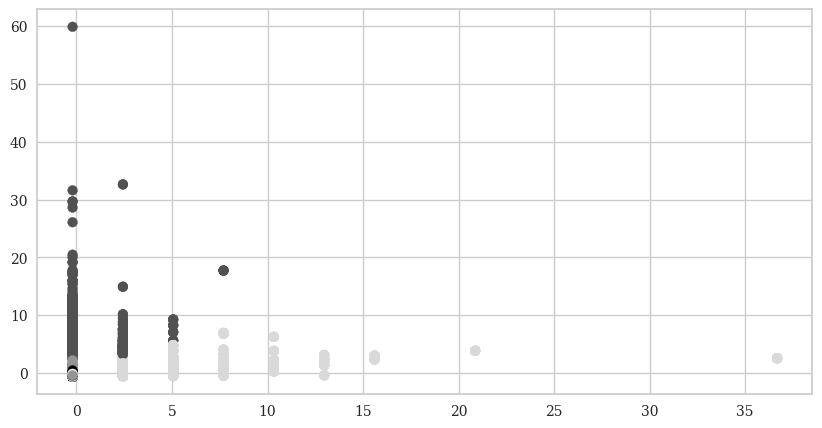

In [84]:
plt.figure(figsize=(10, 5))
plt.scatter(x=df_kmean_new.iloc[:, 1],
            y=df_kmean_new.iloc[:, 2], c=kmeans_segmentation.labels_)

### K-mean (avec ACP)

#### ACP Transformation 

In [85]:
acp = PCA(random_state=42)
acp.fit(kmeans_new_features)

PCA(random_state=42)

In [86]:
acp.explained_variance_ratio_
explained_variance_ratio = acp.explained_variance_ratio_

([<matplotlib.axis.XTick at 0x7f68a0f270b0>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

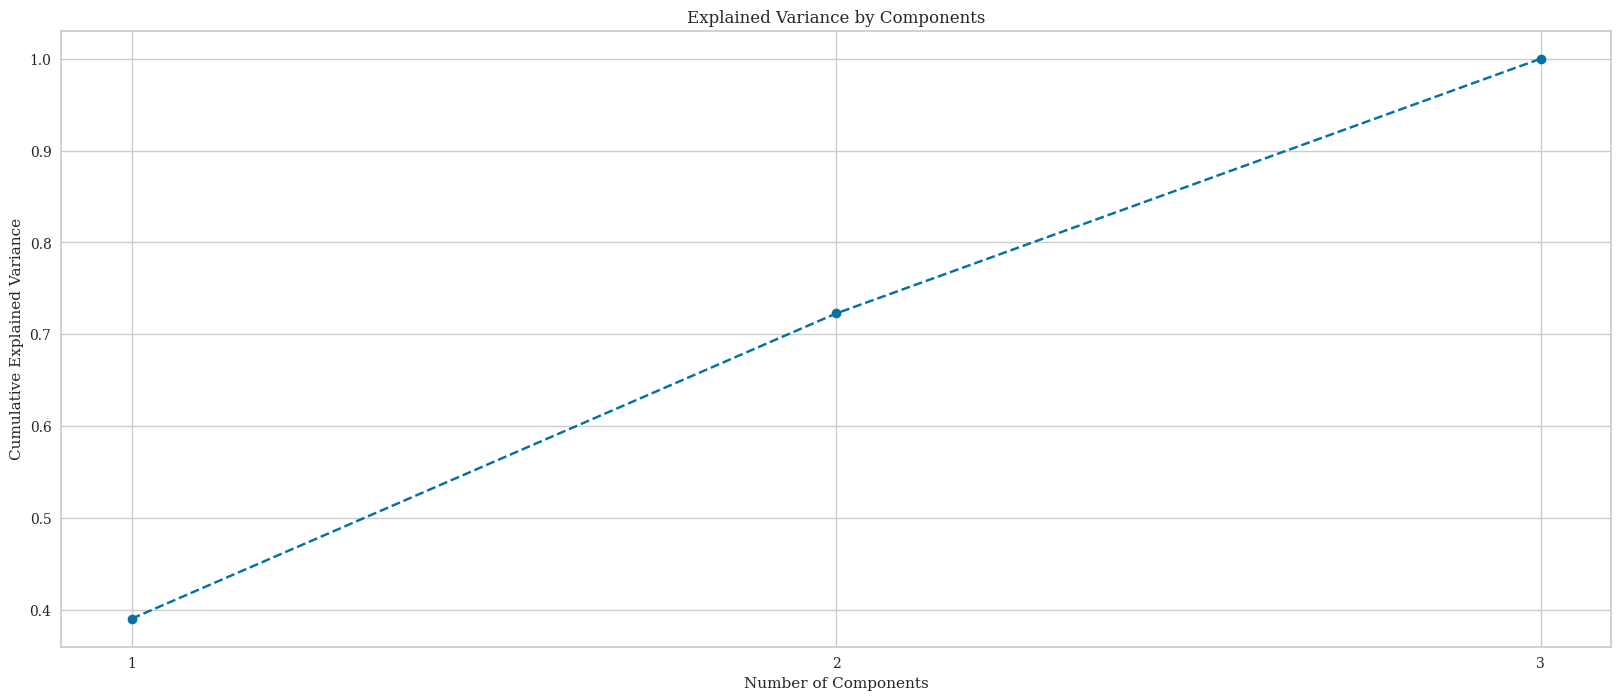

In [87]:
plt.figure(figsize=(20, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio.cumsum(),
         marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))

2 composent explique 80% de la variance 

In [88]:
# Choose number of component ACP
acp = PCA(n_components=2)
# fit data with ACP
acp.fit(kmeans_new_features)
components = acp.components_

In [89]:
score_acp_k_means_new = acp.transform(kmeans_new_features)

In [90]:
# Application du K-Means sur les données transformées par l'ACP
kmeans_with_acp_new = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_with_acp_new.fit(score_acp_k_means_new)

KMeans(n_clusters=5, random_state=42)

In [92]:
# Create a new Dataframe to result of ACP
df_segment_acp_kmeans_new = pd.concat([kmeans_new_features.reset_index(
    drop=True), pd.DataFrame(score_acp_k_means_new)], axis=1)
df_segment_acp_kmeans_new.columns.values[-2:] = ['component_1', 'component_2']
df_segment_acp_kmeans_new["segment_kmeans_acp"] = kmeans_with_acp_new.labels_
df_kmean_new = df_kmean_new.reset_index(drop=True)
df_segment_acp_kmeans_new = df_segment_acp_kmeans_new.reset_index(drop=True)
# Add result to Principal Dataframe
df_kmean_new['component_1'] = df_segment_acp_kmeans_new['component_1']
df_kmean_new['component_2'] = df_segment_acp_kmeans_new['component_2']
df_kmean_new['segment_kmeans_acp'] = df_segment_acp_kmeans_new['segment_kmeans_acp']


df_kmean_new.head()

,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score,component_1,component_2,segment_kmeans_acp
0,-0.825585,-0.200448,-0.074179,0,0.715236,0.641802,108940.00184,-0.032908,-0.826933,0
1,-0.805902,-0.200448,-0.574410,0,0.715236,0.641802,108940.00184,-0.379094,-0.925020,0
2,1.969343,-0.200448,-0.348630,2,0.715236,0.641802,108940.00184,-0.758429,1.823845,1
3,0.552197,-0.200448,-0.542459,4,0.715236,0.641802,108940.00184,-0.618483,0.401767,4
4,0.335688,-0.200448,0.151602,4,0.715236,0.641802,108940.00184,-0.101761,0.354066,4


In [93]:
mapping = {
    0: 'premier',
    1: 'deuxième',
    2: 'troisième',
    3: 'quatrième',
    4: 'cinquième',

}

# Application du mapping pour créer la colonne 'segment'
df_kmean_new['segment'] = df_kmean_new['segment_kmeans_acp'].map(
    mapping)

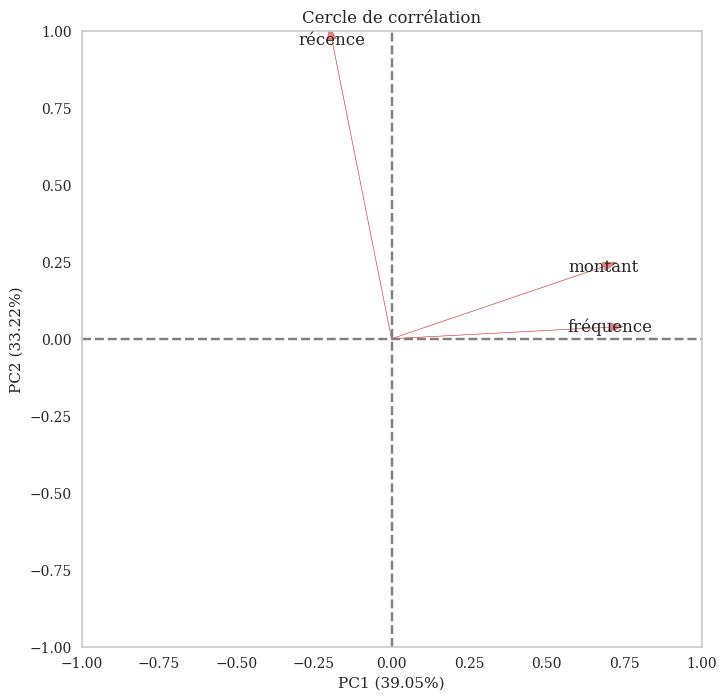

In [94]:
# Plot du cercle de corrélation
def correlation_circle(components, labels, acp):
    plt.figure(figsize=(8, 8))
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    for i, (component_1, component_2) in enumerate(components.T[:, :2]):
        plt.arrow(0, 0, component_1, component_2,
                  color='r', alpha=0.5, head_width=0.03)
        plt.text(component_1, component_2, labels[i],
                 fontsize=12, ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel(f"PC1 ({acp.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({acp.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title('Cercle de corrélation')
    plt.grid()
    plt.show()


# Noms des colonnes pour les étiquettes
labels = kmeans_new_features.columns

# Création du cercle de corrélation
correlation_circle(components, labels, acp)

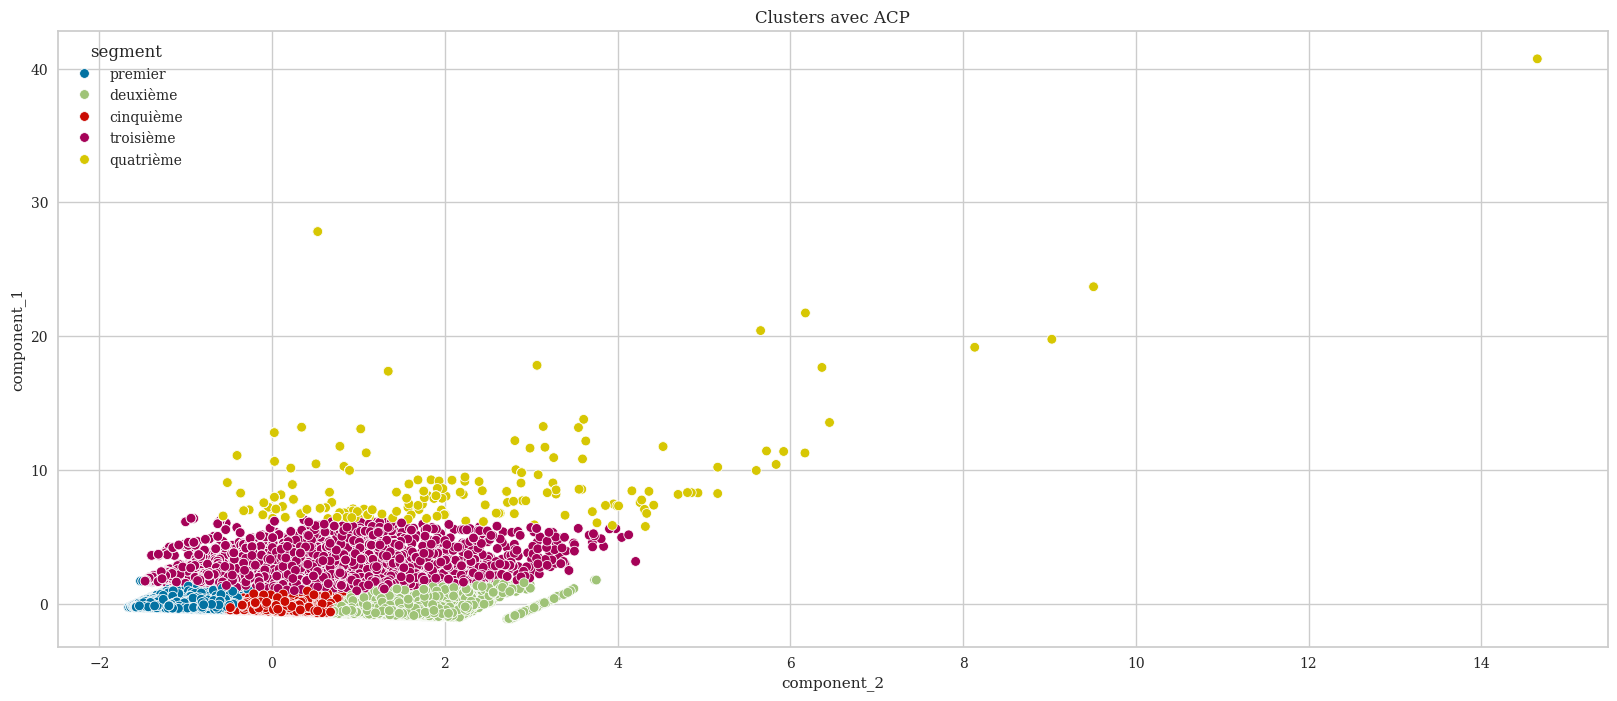

In [96]:
# Plot data by PCA component
x_axis = df_kmean_new['component_2']
y_axis = df_kmean_new['component_1']
plt.figure(figsize=(20, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_kmean_new['segment'])
plt.title('Clusters avec ACP')
plt.show()

### K-means (avec TSNE)

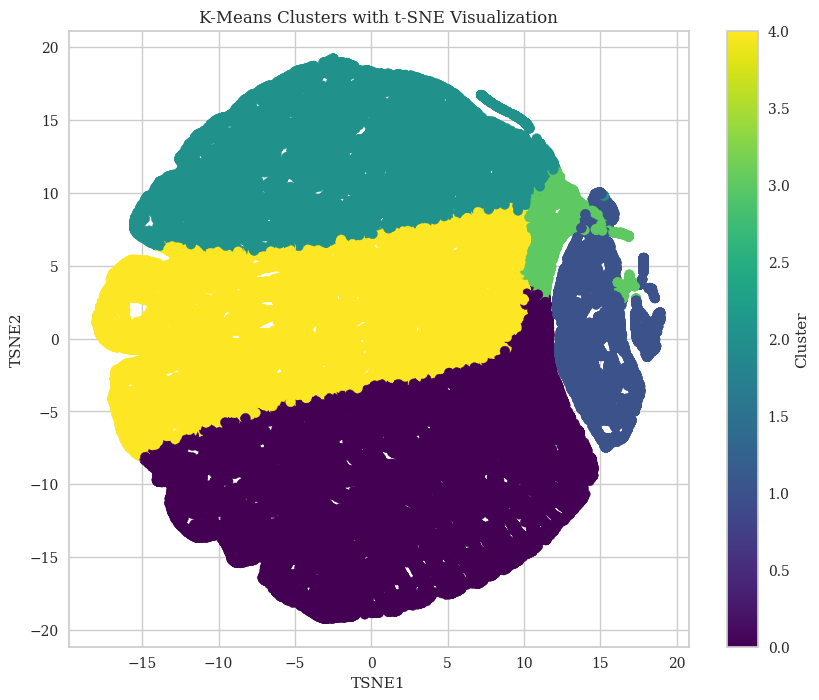

In [99]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_kmean_new['Cluster_TSNE'] = kmeans.fit_predict(kmeans_new_features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(kmeans_new_features)

# Add t-SNE results to the DataFrame
df_kmean_new['TSNE1'] = tsne_results[:, 0]
df_kmean_new['TSNE2'] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_kmean_new['TSNE1'], df_kmean_new['TSNE2'],
            c=df_kmean_new['Cluster_TSNE'], cmap='viridis')
plt.title('K-Means Clusters with t-SNE Visualization')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.colorbar(label='Cluster')
plt.show()

In [103]:
display(df_kmean_new)

,récence,fréquence,montant,Cluster_Label,Silhouette_Score,Davies_Bouldin_Score,Calinski_Harabasz_Score,component_1,component_2,segment_kmeans_acp,segment,Cluster_TSNE,TSNE1,TSNE2
0,-0.825585,-0.200448,-0.074179,0,0.715236,0.641802,108940.00184,-0.032908,-0.826933,0,premier,0,4.633547,-6.653688
1,-0.805902,-0.200448,-0.574410,0,0.715236,0.641802,108940.00184,-0.379094,-0.925020,0,premier,0,-11.418653,-11.985811
2,1.969343,-0.200448,-0.348630,2,0.715236,0.641802,108940.00184,-0.758429,1.823845,1,deuxième,2,-2.180329,14.992532
3,0.552197,-0.200448,-0.542459,4,0.715236,0.641802,108940.00184,-0.618483,0.401767,4,cinquième,4,-12.847163,4.285878
4,0.335688,-0.200448,0.151602,4,0.715236,0.641802,108940.00184,-0.101761,0.354066,4,cinquième,4,4.418424,5.331041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96677,1.378865,-0.200448,6.415765,3,0.715236,0.641802,108940.00184,3.985263,2.835170,2,troisième,3,13.588387,9.286026
96678,0.165106,-0.200448,-0.367152,4,0.715236,0.641802,108940.00184,-0.424023,0.066810,4,cinquième,4,-5.925014,0.796507
96679,2.172730,-0.200448,-0.254442,2,0.715236,0.641802,108940.00184,-0.733085,2.043490,1,deuxième,2,0.314390,17.073225
96680,-0.773098,-0.200448,-0.141327,0,0.715236,0.641802,108940.00184,-0.088967,-0.791679,0,premier,0,2.874310,-6.301033


### Analyse des segments clients avec les clusters (5 cluster kmeans)

In [108]:
# Merge two dataframe for add Cluster_Label columns
df_without_preprocessing = pd.read_csv('df_cleaning.csv')
# df_without_preprocessing.set_index('identifiant_client')

df1_reset_new = df_without_preprocessing.reset_index()
df2_reset_new = df_kmean_new.reset_index()
df2_reset_new['identifiant_client'] = df_without_preprocessing['identifiant_client']

df_with_cluster_new = pd.merge(df1_reset_new, df2_reset_new[[
                           'identifiant_client', 'Cluster_Label']], on='identifiant_client', how='left')


df_with_cluster_new.set_index('identifiant_client', inplace=True)


display(df_with_cluster_new.head())

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label
identifiant_client,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,0.00,0.0,0.0,0.0,0.0,27.19,0.0,0.0,0.0,0
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,43.62,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,4
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,196.89,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,4


### Création du Segment RFM

In [115]:
df_with_cluster_new["récence_score"] = pd.qcut(
    df_with_cluster_new['récence'], 5, labels=[5, 4, 3, 2, 1])
df_with_cluster_new["fréquence_score"] = pd.qcut(
    df_with_cluster_new['fréquence'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_with_cluster_new["montant_score"] = pd.qcut(
    df_with_cluster_new['montant'], 5, labels=[1, 2, 3, 4, 5])

In [116]:
df_with_cluster_new['RFM_SCORE'] = df_with_cluster_new.récence_score.astype(
    str) + df_with_cluster_new.fréquence_score.astype(str) + df_with_cluster_new.montant_score.astype(str)
df_with_cluster_new

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.00,0.00,0.0,0.0,0,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,0.00,27.19,0.00,0.0,0.0,0,4,1,1,411
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.00,0.00,0.0,0.0,2,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,4,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.00,0.00,0.0,0.0,4,2,1,4,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,96677,447.0,1,1570.00,credit_card,sanharo,PE,Jeudi,health_beauty,0.0,...,0.00,4134.84,0.00,0.0,0.0,3,1,5,5,155
fffea47cd6d3cc0a88bd621562a9d061,96678,262.0,1,64.89,credit_card,feira de santana,BA,Dimanche,baby,0.0,...,0.00,0.00,84.58,0.0,0.0,4,3,5,2,352
ffff371b4d645b6ecea244b27531430a,96679,568.0,1,89.90,credit_card,sinop,MT,Mardi,auto,0.0,...,112.46,0.00,0.00,0.0,0.0,2,1,5,3,153


In [117]:
seg_map = {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [118]:
df_with_cluster_new['Segment'] = df_with_cluster_new['récence_score'].astype(
    str) + df_with_cluster_new['fréquence_score'].astype(str) + df_with_cluster_new['montant_score'].astype(str)
df_with_cluster_new['Segment'] = df_with_cluster_new['Segment'].replace(
    seg_map, regex=True)
df_with_cluster_new.head()

,index,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,...,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services,Cluster_Label,récence_score,fréquence_score,montant_score,RFM_SCORE,Segment
identifiant_client,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,...,0.00,0.0,0.0,0.0,0,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,27.19,0.0,0.0,0.0,0,4,1,1,411,New Customers
0000f46a3911fa3c0805444483337064,2,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.00,0.0,0.0,0.0,2,1,1,2,112,Lost customers
0000f6ccb0745a6a4b88665a16c9f078,3,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.00,0.0,0.0,0.0,4,2,1,1,211,Hibernating customers
0004aac84e0df4da2b147fca70cf8255,4,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.00,0.0,0.0,0.0,4,2,1,4,214,Cannot Lose Them


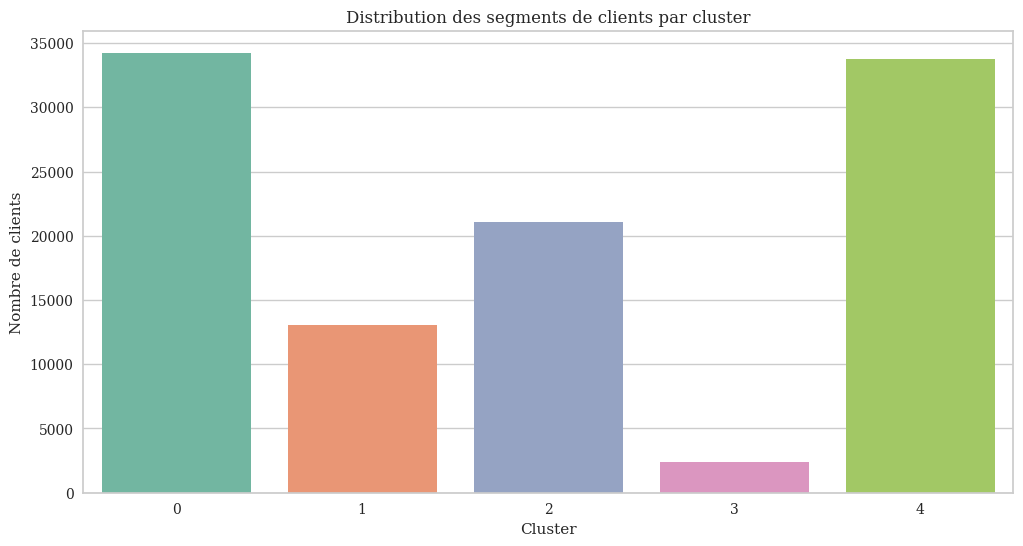

In [109]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_with_cluster_new, x='Cluster_Label', palette='Set2')
plt.title('Distribution des segments de clients par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

In [111]:
# Filtrer le DataFrame pour les Cluster_Label spécifiques
filtered_clusters = df_with_cluster_new[df_with_cluster_new['Cluster_Label'].isin([0,1,2,3,4])]

# Compter le nombre de valeurs pour chaque Cluster_Label
cluster_counts = filtered_clusters['Cluster_Label'].value_counts()

# Afficher les résultats
print(cluster_counts)

Cluster_Label
0    34252
4    33795
2    21044
1    13041
3     2384
Name: count, dtype: int64


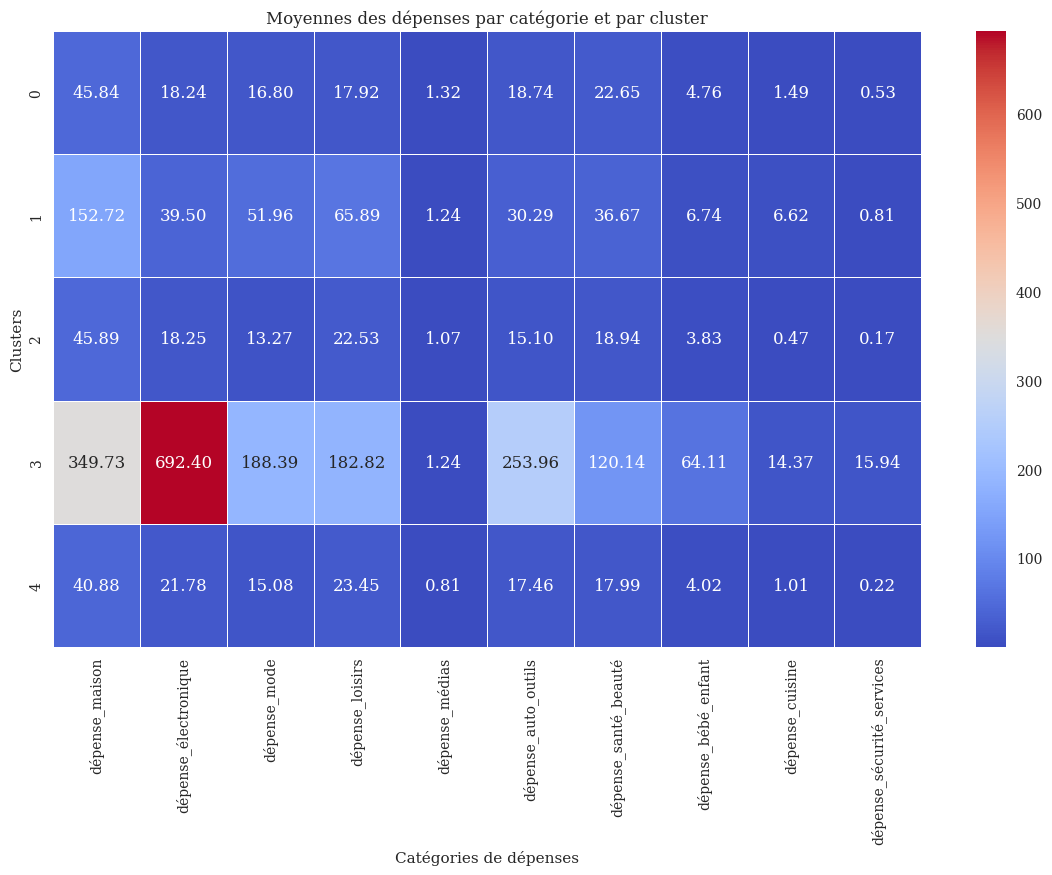

In [112]:
# Filtrer les colonnes numériques seulement pour le calcul des moyennes
numeric_cols = df_with_cluster_new.select_dtypes(include=['number']).columns

# Calculer la moyenne des dépenses par catégorie pour chaque cluster
depense_par_cluster = df_with_cluster_new.groupby(
    'Cluster_Label')[numeric_cols].mean().filter(like='dépense')

# Créer une heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(depense_par_cluster, annot=True,
            fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Moyennes des dépenses par catégorie et par cluster')
plt.xlabel('Catégories de dépenses')
plt.ylabel('Clusters')
plt.show()

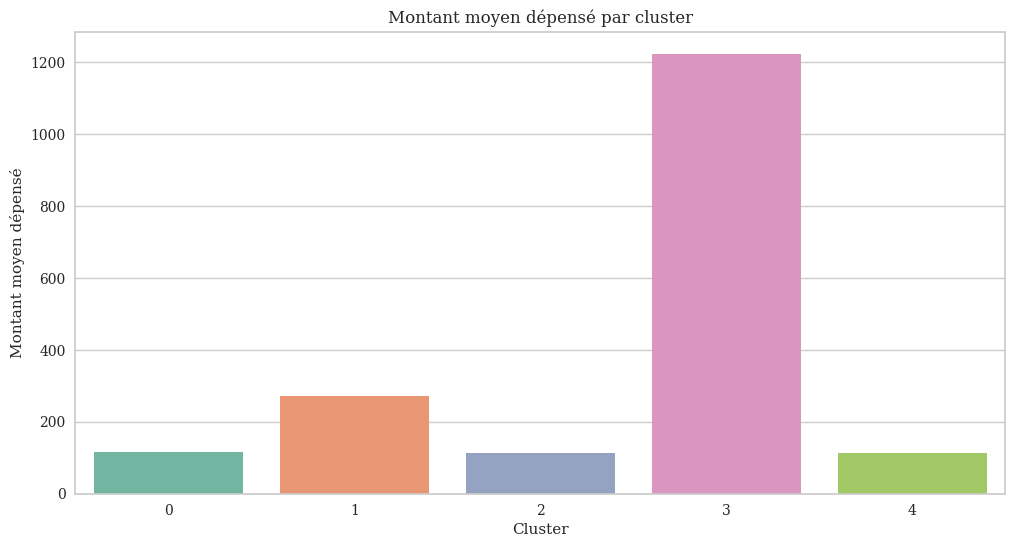

In [119]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_with_cluster_new, x='Cluster_Label',
            y='montant', palette='Set2', ci=None)
plt.title('Montant moyen dépensé par cluster')
plt.xlabel('Cluster')
plt.ylabel('Montant moyen dépensé')
plt.show()

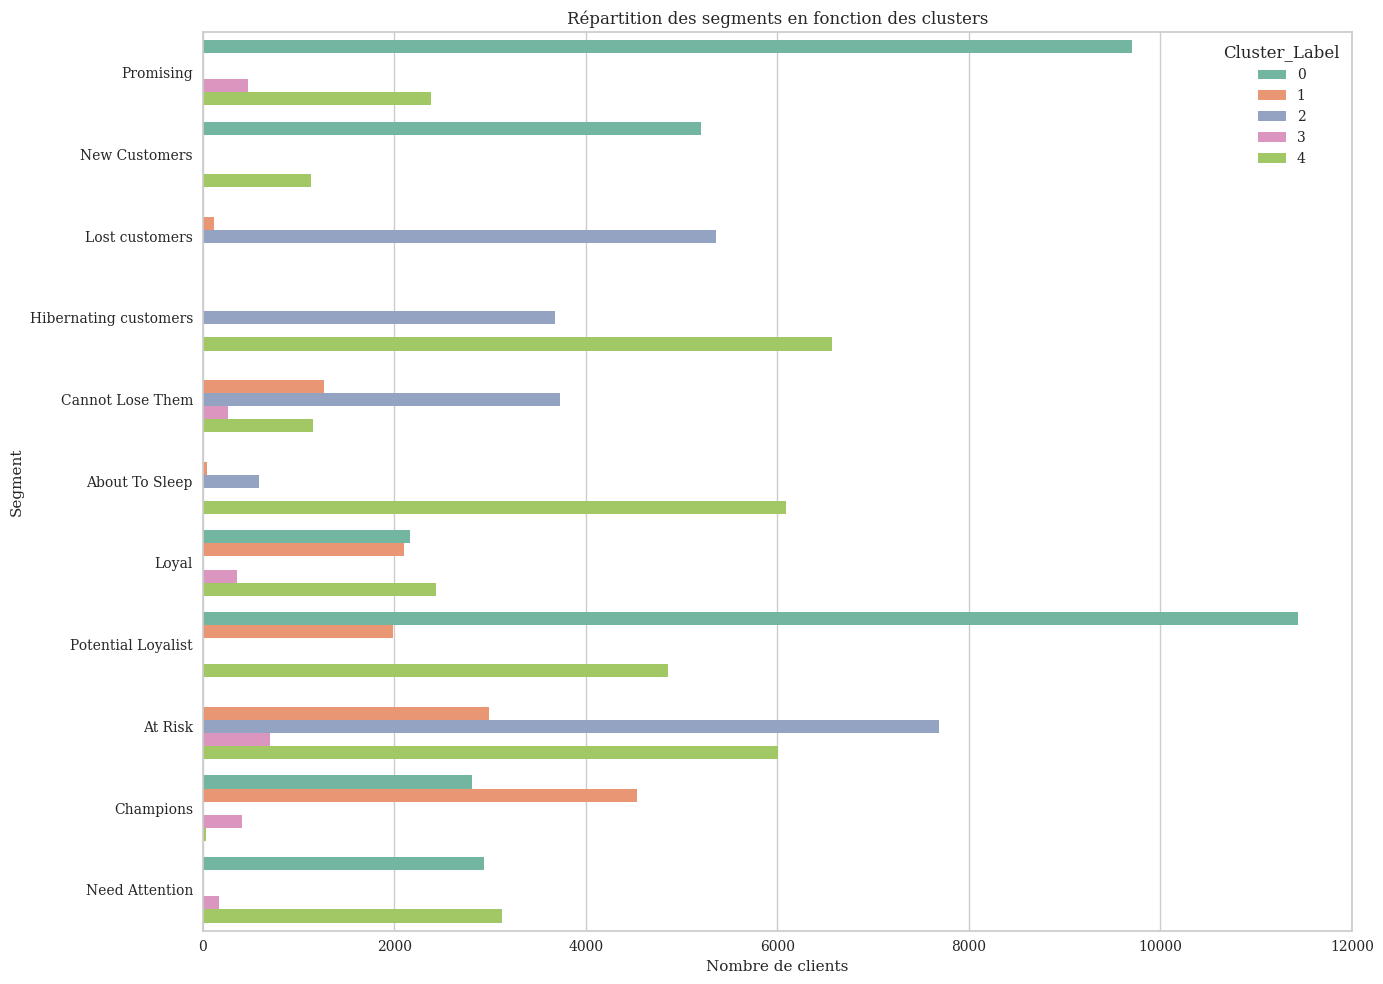

In [120]:
# Augmenter la taille de la figure pour un affichage horizontal
plt.figure(figsize=(14, 10))
sns.countplot(data=df_with_cluster_new, y='Segment',
              hue='Cluster_Label', palette='Set2',)

plt.title('Répartition des segments en fonction des clusters')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')

# Ajuster les espacements
plt.tight_layout()

plt.show()


---

 **Cluster 0**
- **Caractéristiques :**
  - **Taille Importante** : Le plus grand cluster en nombre de clients.
  - **Dépenses Modérées** : Les dépenses sont globalement faibles dans toutes les catégories, avec une légère concentration sur les catégories "dépense_maison" et "dépense_électronique".
  - **Segments Dominants** : Ce cluster contient majoritairement des segments "Potential Loyalist" et "Promising".

- **Actions Marketing :**
  - **Renforcement de la Fidélisation :** Proposer des offres exclusives ou des programmes de fidélité pour transformer ces clients prometteurs en clients fidèles.
  - **Campagnes Ciblées :** Utiliser des campagnes ciblées pour stimuler les dépenses dans des catégories sous-représentées, telles que "mode" ou "loisirs".


---

 **Cluster 1**
- **Caractéristiques :**
  - **Taille Modérée** : Nombre significatif de clients avec des dépenses un peu plus élevées.
  - **Dépenses Élevées en Maison et Mode** : Ce cluster montre des dépenses relativement plus élevées dans les catégories "dépense_maison", "dépense_mode", et "dépense_loisirs".
  - **Segments Représentés** : Ce cluster inclut des segments comme "Cannot Lose Them" et "Champions".

- **Actions Marketing :**
  - **Offres Premium :** Introduire des services ou produits premium dans les catégories maison et mode pour répondre aux attentes de ce groupe.
  - **Engagement Personnalisé :** Offrir des avantages exclusifs aux segments "Champions" pour renforcer leur loyauté.

---

 **Cluster 2**
- **Caractéristiques :**
  - **Taille Moyenne** : Taille de client moyenne avec des dépenses faibles à modérées.
  - **Dépenses Uniformes** : Les dépenses sont assez uniformes à travers les différentes catégories, avec une légère préférence pour les catégories "loisirs" et "santé_beauté".
  - **Segments Inclus** : Ce cluster contient des segments comme "At Risk" et "Hibernating Customers".

- **Actions Marketing :**
  - **Campagnes de Réactivation :** Mettre en place des campagnes de réactivation pour les clients en hibernation, en leur offrant des promotions sur leurs catégories préférées.
  - **Programmes de Récupération :** Proposer des remises ou des incitations spécifiques aux clients du segment "At Risk" pour éviter qu'ils ne se désengagent complètement.

---

 **Cluster 3**
- **Caractéristiques :**
  - **Petit Taille avec Dépenses Élevées** : Ce cluster est petit mais se distingue par des dépenses très élevées, notamment dans les catégories "dépense_électronique" et "dépense_maison".
  - **Segments Principaux** : Contient des segments tels que "Champions" et "Loyal".

- **Actions Marketing :**
  - **Programme VIP :** Créer un programme VIP exclusif pour récompenser ces clients très dépensiers, avec des avantages premium et un service client dédié.
  - **Cross-Selling et Upselling :** Proposer des produits complémentaires de haute valeur dans les catégories "électronique" et "maison".
  - **Expériences Personnalisées :** Offrir des expériences sur mesure, comme des invitations à des événements privés ou des pré-lancements de produits.

---

 **Cluster 4**
- **Caractéristiques :**
  - **Taille Importante, Dépenses Modérées** : Un grand nombre de clients avec des dépenses modérées.
  - **Dépenses Relativement Uniformes** : Les dépenses sont réparties uniformément, avec une légère préférence pour "dépense_maison" et "dépense_loisirs".
  - **Segments Dominants** : Ce cluster contient de nombreux clients "Promising" et "At Risk".

- **Actions Marketing :**
  - **Incitations à la Fidélité :** Offrir des incitations pour encourager ces clients à augmenter leurs dépenses dans les catégories sous-représentées.
  - **Programmes de Récompenses :** Lancer des programmes de récompenses qui permettent aux clients de gagner des points pour chaque achat, ce qui pourrait les motiver à dépenser plus.
  - **Optimisation des Campagnes Marketing :** Affiner les campagnes marketing pour mieux cibler les segments "At Risk" afin d'augmenter leur engagement et réduire le risque de churn.




## Simulation d'un contrat de maintenance 

ARI Adjusted Rand Index

Prédictions sur les Périodes Suivantes : Appliquez le modèle à des périodes subséquentes et enregistrez les labels prédits.
Calcul de l'ARI : Calculez l'ARI entre les labels de la période initiale et ceux des périodes suivantes.
Interprétation de l'ARI : Un ARI proche de 1 indique que les clusters sont stables, tandis qu'un ARI faible indique une divergence significative.

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Exemple de calcul de l'ARI
labels_initial = model.fit_predict(data_initial)
labels_following = model.predict(data_following)
ari_score = adjusted_rand_score(labels_initial, labels_following)

Analyse de la Distribution des Features :

    Distribution Graphique : Utilisez des visualisations comme les boxplots et les histograms pour examiner l'évolution des distributions des features.
    Test de Kolmogorov-Smirnov (KS) :
        Comparez la distribution des features entre les périodes.
        Un test KS significatif indique que la distribution d'une feature a changé.

```python
from scipy.stats import ks_2samp

# Exemple de test de Kolmogorov-Smirnov
ks_stat, p_value = ks_2samp(data_period1['feature'], data_period2['feature'])

```
Détermination du Moment de Réentraîner le Modèle :

    Critère ARI : Fixez un seuil pour l'ARI en dessous duquel le modèle doit être réentraîné.
    Observation des Distributions : Si des changements significatifs sont détectés dans la distribution des features, considérez un réentraînement du modèle.

### ACH

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Supposons que 'data' soit votre DataFrame de caractéristiques
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_

# Calcul de la matrice des distances entre les centroides
distances = squareform(pdist(centroids, metric='euclidean'))

# Classification Hiérarchique Ascendante sur les distances des centroides
Z = linkage(distances, method='ward')

# Visualisation du dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f"Cluster {i}" for i in range(len(centroids))])
plt.title("Dendrogramme des clusters après K-Means")
plt.xlabel("Clusters")
plt.ylabel("Distance")
plt.show()

# Découper le dendrogramme pour obtenir de nouveaux clusters
# t est le nombre de clusters désiré
new_labels = fcluster(Z, t=3, criterion='maxclust')

# Analyse des nouveaux clusters
# Ici vous pouvez explorer ou visualiser les nouveaux clusters

# Exemple de visualisation des nouveaux clusters
plt.figure(figsize=(10, 7))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=new_labels, cmap='rainbow')
plt.title("Visualisation des nouveaux clusters")
plt.show()

## Radar chart

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Supposons que df_with_cluster soit votre DataFrame avec les colonnes 'Cluster_Label' et les catégories de dépenses

# Calcul de la moyenne des variables par cluster
moyennes_par_cluster = df_with_cluster.groupby('Cluster_Label').mean()

# Choisir les colonnes que vous voulez inclure dans le radar chart
categories = moyennes_par_cluster.columns.tolist()

# Nombre de variables
N = len(categories)

# Création des angles pour chaque catégorie
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialiser le radar chart
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Ajouter les labels pour chaque axe
plt.xticks(angles[:-1], categories)

# Tracer un axe pour chaque cluster
for i in range(len(moyennes_par_cluster)):
    values = moyennes_par_cluster.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid',
            label=f'Cluster {moyennes_par_cluster.index[i]}')
    ax.fill(angles, values, alpha=0.25)

# Ajouter la légende
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Afficher le radar chart
plt.title('Moyenne des variables par cluster')
plt.show()